In [1]:
import pandas as pd
import glob
import os
from collections import OrderedDict
import matplotlib.pyplot as plt
import ntpath
from tslearn.utils import to_time_series
from tslearn.clustering import TimeSeriesKMeans
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
import numpy as np

/Users/audi/miniconda3/envs/viz-scripts/lib/python3.7/site-packages/tslearn/bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)
/Users/audi/miniconda3/envs/viz-scripts/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.cluster.k_means_ module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.cluster. Anything that cannot be imported from sklearn.cluster is now part of the private API.
  warnings.warn(message, FutureWarning)


# Load data

In [2]:
input_dir = "/Users/audi/Downloads/excel in"

In [3]:
def clean(x: object) -> object:
    """Clean a cell value.
    In this case, if it's a string, we will ignore it (i.e. make it nan).

    Parameters
    ----------
    x : object
        Value of a dataframe cell

    Returns
    -------
    object
        nan if it's a string, it's original value otherwise.
    """
    if isinstance(x, str):
        return np.nan
    return x

In [4]:
min_time = -200
max_time = 0

In [5]:
dfs = OrderedDict()
files = glob.glob(os.path.join(input_dir, "*.xlsx"))
files.sort(key=lambda x: int(x.split('/')[-1].split('_')[0]))
for file in files:
    df = pd.read_excel(file, header=0)
    df.set_index(df.columns[0], inplace=True)
    name = ntpath.basename(file).split("equatorial")[0].strip().replace(' ', '_')
    dfs[name] = {}
    for i in range(0, len(df.columns), 6):
        df_slice = df.iloc[:, i:i+6]
        df_slice = df_slice.applymap(clean)
        df_slice = df_slice[(df_slice.index >= min_time) & (df_slice.index <= max_time)]
        film_name = df_slice.columns[0]
        df_slice.columns = list(range(6))
        dfs[name][film_name] = df_slice

In [6]:
print(f'Found {len(dfs.keys())} conditions: {dfs.keys()}')

Found 16 conditions: odict_keys(['0_JDU233_WT_ex_utero', '0_JDU233_WT_in_utero', '1_JDU233_knl-1', '2_JDU233_him-10', '3_JDU233_zwl-1', '4_JDU233_him-10_zwl-1', '5_JDU233_gei-17', '6_JDU233_klp-19', '7_JDU323_WT', '8_JDU323_knl1', '9_JDU323_knl1_him_10', '10_JDU323_knl1_zwl1', '11_JDU574_WT', '12_JDU574_zwl1', '13_JDU574_zwl1_him10', '14_JDU574_zwl1_klp19'])


# Simple statistics

## number of films for each condition
First, we want to see the number of films we have for each condition in our data

In [7]:
nb_films = [len(df.keys()) for _, df in dfs.items()]

In [8]:
plt.barh(list(dfs.keys()), nb_films)

<BarContainer object of 16 artists>

In [64]:
print(f"Total number of films: {sum(nb_films)}")

Total number of films: 251


## visualizing chromosome distances
Here we just want to see the distribution of the data: the distance of each chromosome in each film at each timestamps. Each line represents one chromosome.

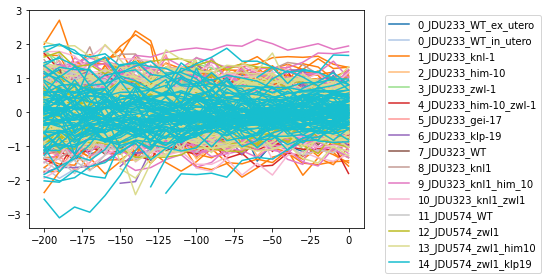

In [202]:
NUM_COLORS = len(dfs.keys())
cm = plt.get_cmap('tab20')
for i, (cond, films) in enumerate(dfs.items()):
    for film, df in films.items():
        plt.plot(df, color=cm(1.*i/NUM_COLORS), label=cond)
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(1.05, 1), loc='upper left')

Note here that the range of the distance is more or less between `-3` to `3`

Let's see an example of just one condition with the least number of films: `9_JDU323_knl1_him_10`:

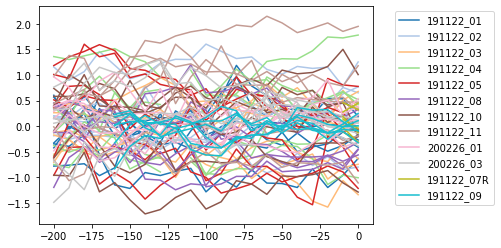

In [203]:
cond = "9_JDU323_knl1_him_10"
films = dfs[cond]
NUM_COLORS = len(films.keys())
for i, (film, df) in enumerate(films.items()):
    plt.plot(df, label=film, color=cm(1.*i/NUM_COLORS), linestyle='-')
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(1.05, 1), loc='upper left')

We can see that not all films have the full observations from timestamp `-200` to `0`

## min/max/avg
Next, we want to compute simple statistics of the values: 
- **min** & **max**: for each pole of the spindle, we get the chromosomes that are closest to the each pole and get their distance from the center
- **average**: we get the average distance of each chromosomes to the center, note that we also take into account the sign (+/-), which means if there are the same amount of chromosomes in both sides, each with same distance, the average distance will be 0

### Of each film
For each film on each condition, we get the max/min/avg distance of the chromosomes in that timestamp. Here each line is for one film.

For example, we see below **each solid line** represents the distances of one chromosome in `191122_01` from condition `9_JDU323_knl1_him_10` above, and the **black dotted lines** are the maximum/minimum/average distance for all chromosomes in this film, while the **black dashed line** is the difference between the maximum & the minimum distance.

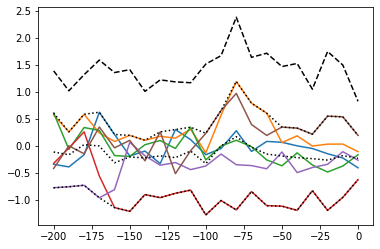

In [39]:
cond = "9_JDU323_knl1_him_10"
film = "191122_01"
df = dfs[cond][film]
plt.plot(df, linestyle='-')
df_max = df.apply(max, axis=1)
df_min = df.apply(min, axis=1)
plt.plot(df_max, color='black', linestyle=':')
plt.plot(df_min, color='black', linestyle=':')
plt.plot(df_max - df_min, color='black', linestyle='--')
plt.plot(df.apply(lambda x: x.mean(), axis=1), color='black', linestyle=':')

Now we compute such max/min/max-min diff/avg values (i.e. the black dotted line) for each of the film on each condition:

Text(0, 0.5, 'Maximum distance')

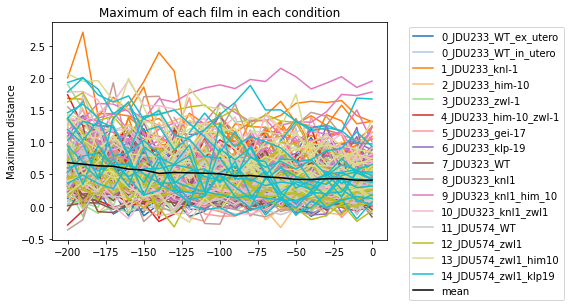

In [68]:
NUM_COLORS = len(dfs.keys())
cm = plt.get_cmap('tab20')
df_maxes = []
for i, (cond, films) in enumerate(dfs.items()):
    for film, df in films.items():
        df_max = df.apply(max, axis=1)
        plt.plot(df_max, color=cm(1.*i/NUM_COLORS), label=cond)
        df_maxes.append(df_max)
plt.plot(pd.concat(df_maxes, axis=1).mean(axis=1), color="black", label="mean")        
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("Maximum of each film in each condition")
plt.ylabel("Maximum distance")

Note above that the range of the value is more or less the *upper* half (`0.5`-`3`) of the overall data (`-3`-`3`). And the descending trend (shown by the `mean`) shows that the chromosomes get closer and closer to the center.

Text(0, 0.5, 'Minimum distance')

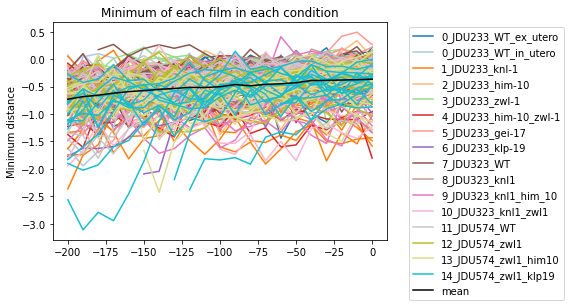

In [70]:
NUM_COLORS = len(dfs.keys())
cm = plt.get_cmap('tab20')
df_mins = []
for i, (cond, films) in enumerate(dfs.items()):
    for film, df in films.items():
        df_min = df.apply(min, axis=1)
        plt.plot(df_min, color=cm(1.*i/NUM_COLORS), label=cond)
        df_mins.append(df_min)
plt.plot(pd.concat(df_mins, axis=1).mean(axis=1), color="black", label="mean")                
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("Minimum of each film in each condition")
plt.ylabel("Minimum distance")

Note above that the range of the value is more or less the *bottom* half (`-3`-`0.5`) of the overall data (`-3`-`3`), and the increasing trend shows the chromosomes getting closer and closer to the center.

Text(0, 0.5, 'Average distance')

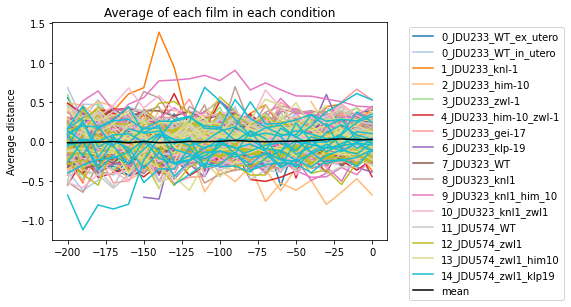

In [71]:
NUM_COLORS = len(dfs.keys())
cm = plt.get_cmap('tab20')
df_means = []
for i, (cond, films) in enumerate(dfs.items()):
    for film, df in films.items():
        df_mean = df.apply(lambda x: x.mean(), axis=1)
        plt.plot(df_mean, color=cm(1.*i/NUM_COLORS), label=cond)
        df_means.append(df_mean)
plt.plot(pd.concat(df_means, axis=1).mean(axis=1), color="black", label="mean")                        
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("Average of each film in each condition")
plt.ylabel("Average distance")

And as expected, the range of the above is more or less the *middle* half (`-1.5`-`1.5`) of the overall data (`-3`-`3`), and there seems to be a constant trend around `0`, which shows that the chromosomes in both sides more or less move closer to the center simultaneously, i.e. when the maximum decreases, the minimum increases, which is shown by the max & min trends in previous plots.

Text(0, 0.5, 'Max-min distance difference')

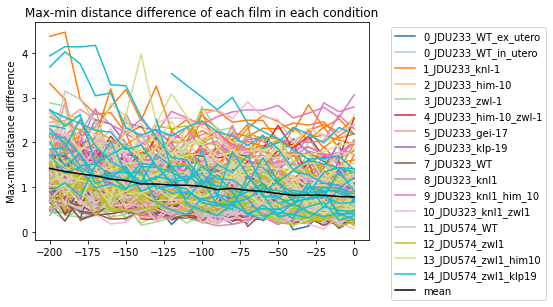

In [73]:
NUM_COLORS = len(dfs.keys())
cm = plt.get_cmap('tab20')
df_deltas = []
for i, (cond, films) in enumerate(dfs.items()):
    for film, df in films.items():
        df_delta = df.apply(max, axis=1)-df.apply(min, axis=1)
        plt.plot(df_delta, color=cm(1.*i/NUM_COLORS), label=cond)
        df_deltas.append(df_delta)
plt.plot(pd.concat(df_deltas, axis=1).mean(axis=1), color="black", label="mean")                                
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("Max-min distance difference of each film in each condition")
plt.ylabel("Max-min distance difference")

The range of the value above is always positive (>`0`), as we compute the difference between the maximum & the minimum distance. We see also the decreasing trend here, showing that the chromosomes get closer to each other over time, which we can already assume from the above plots.

### AVG of all films
Now, from the values we compute above (max/min/avg of each film), we want to take an average of those values for each condititions.

For example, we use again the condition `9_JDU323_knl1_him_10`, each **solid line** below represents the maximum values of each film. The **black dotted line** represents the average of those maximums for all films for condition `9_JDU323_knl1_him_10`.

Text(0, 0.5, 'Max distance')

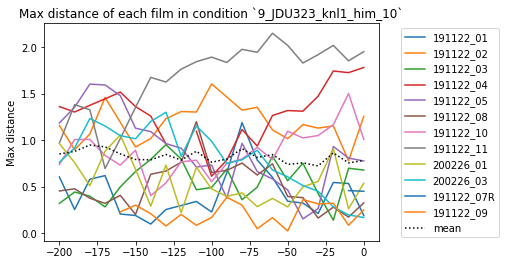

In [84]:
cond = "9_JDU323_knl1_him_10"
df_maxes = []
for film, df in dfs[cond].items():
    df_max = df.apply(max, axis=1)
    plt.plot(df_max, label=film, linestyle='-')
    df_maxes.append(df_max)
plt.plot(pd.concat(df_maxes, axis=1).mean(axis=1), color="black", label="mean", linestyle=":")                                
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title(f"Max distance of each film in condition `{cond}`")
plt.ylabel("Max distance")

We compute such average statistics for max/min/avg for each condition below.

Text(0, 0.5, 'Average max distance')

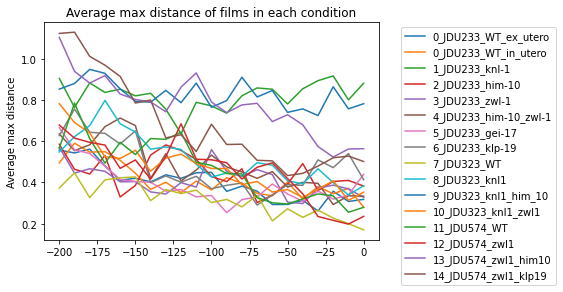

In [87]:
for cond, films in dfs.items():
    df_maxes = []
    for film, df in films.items():
        df_max = df.apply(max, axis=1)
        df_maxes.append(df_max)
    plt.plot(pd.concat(df_maxes, axis=1).mean(axis=1), label=cond, linestyle="-")                                
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title(f"Average max distance of films in each condition")
plt.ylabel("Average max distance")

Text(0, 0.5, 'Average min distance')

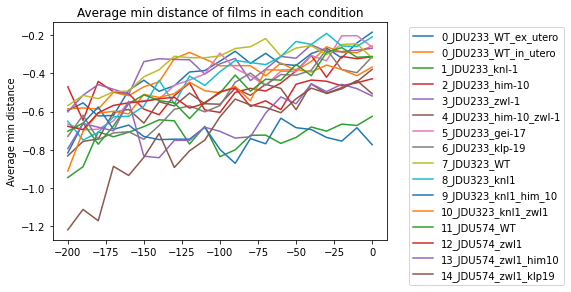

In [88]:
for cond, films in dfs.items():
    df_all = []
    for film, df in films.items():
        df_max = df.apply(min, axis=1)
        df_all.append(df_max)
    plt.plot(pd.concat(df_all, axis=1).mean(axis=1), label=cond, linestyle="-")                                
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title(f"Average min distance of films in each condition")
plt.ylabel("Average min distance")

Text(0, 0.5, 'Average avg distance')

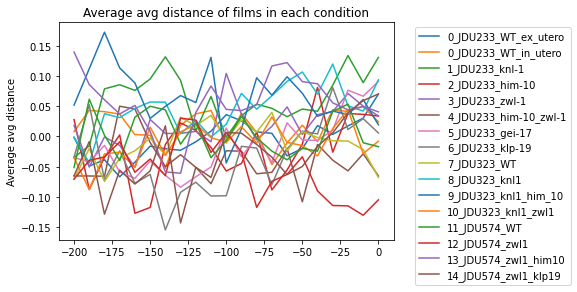

In [89]:
for cond, films in dfs.items():
    df_all = []
    for film, df in films.items():
        df_max = df.apply(lambda x: x.mean(), axis=1)
        df_all.append(df_max)
    plt.plot(pd.concat(df_all, axis=1).mean(axis=1), label=cond, linestyle="-")                                
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title(f"Average avg distance of films in each condition")
plt.ylabel("Average avg distance")

Text(0, 0.5, 'Average max-min distance difference')

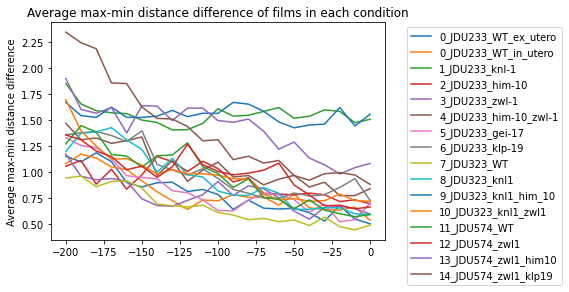

In [90]:
for cond, films in dfs.items():
    df_all = []
    for film, df in films.items():
        df_max = df.apply(max, axis=1)
        df_min = df.apply(min, axis=1)
        df_delta = df_max - df_min
        df_all.append(df_delta)
    plt.plot(pd.concat(df_all, axis=1).mean(axis=1), label=cond, linestyle="-")                                
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title(f"Average max-min distance difference of films in each condition")
plt.ylabel("Average max-min distance difference")

# Clustering
Here, we would like to compare at how these values move over time (their dynamics) for each condition. In another word, we only want to compare the ***shape*** of each curve in an ***amplitude-invariant*** manner. The fact that it's *amplitude-invariant* means we are only comparing the patterns of **how** these value changes, without taking into account of **how much** they change. 

For example, the two curves below look like their value changes differently over time: 
![Original curves](Unknown)
But after proper scaling, we can see that their value fluctuates in a similar manner:
![Scaled curves](Unknown-2)

For this clustering analysis, we would like to compare the shapes that has been scaled as in the last image above.

## Scaled data
To be precise, we are scaling the curves such that the mean is `0` and the variance (or standard deviation, in this matter) is `1`.

In [143]:
avg_maxs = []
for cond, films in dfs.items():
    df_all = []
    for film, df in films.items():
        df_max = df.apply(max, axis=1)
        df_all.append(df_max)
    avg_maxs.append(to_time_series(pd.concat(df_all, axis=1).mean(axis=1)))
avg_maxs = np.array(avg_maxs)    

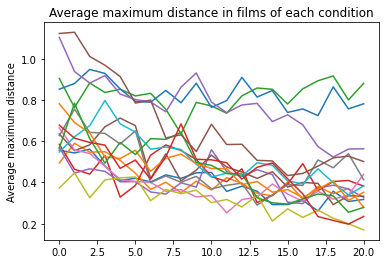

In [144]:
for avg_max in avg_maxs:
    plt.plot(avg_max)
plt.title(f"Average maximum distance in films of each condition")
plt.ylabel("Average maximum distance")

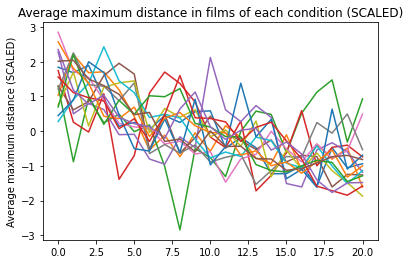

In [145]:
avg_maxs_scaled = TimeSeriesScalerMeanVariance().fit_transform(avg_maxs)
for avg_max in avg_maxs_scaled:
    plt.plot(avg_max)
plt.title(f"Average maximum distance in films of each condition (SCALED)")
plt.ylabel("Average maximum distance (SCALED)")

In [146]:
avg_mins = []
for cond, films in dfs.items():
    df_all = []
    for film, df in films.items():
        df_min = df.apply(min, axis=1)
        df_all.append(df_min)
    avg_mins.append(to_time_series(pd.concat(df_all, axis=1).mean(axis=1)))
avg_mins = np.array(avg_mins)    

Text(0, 0.5, 'Average minimum distance')

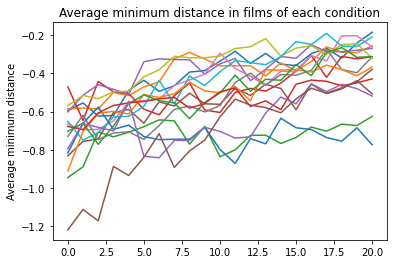

In [147]:
for avg_min in avg_mins:
    plt.plot(avg_min)
plt.title(f"Average minimum distance in films of each condition")
plt.ylabel("Average minimum distance")

Text(0, 0.5, 'Average maximum distance (SCALED)')

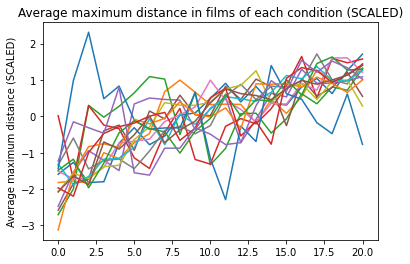

In [148]:
avg_mins_scaled = TimeSeriesScalerMeanVariance().fit_transform(avg_mins)
for avg_min in avg_mins_scaled:
    plt.plot(avg_min)
plt.title(f"Average maximum distance in films of each condition (SCALED)")
plt.ylabel("Average maximum distance (SCALED)")

In [154]:
avg_avgs = []
for cond, films in dfs.items():
    df_all = []
    for film, df in films.items():
        df_avg = df.apply(lambda x: x.mean(), axis=1)
        df_all.append(df_avg)
    avg_avgs.append(to_time_series(pd.concat(df_all, axis=1).mean(axis=1)))
avg_avgs = np.array(avg_avgs)    

Text(0, 0.5, 'Average of average distance')

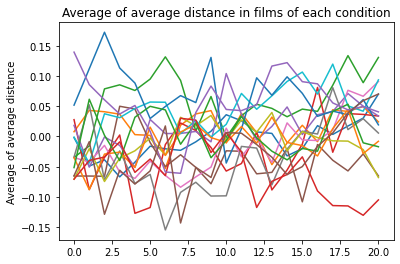

In [155]:
for avg_avg in avg_avgs:
    plt.plot(avg_avg)
plt.title(f"Average of average distance in films of each condition")
plt.ylabel("Average of average distance")

Text(0, 0.5, 'Average of average distance (SCALED)')

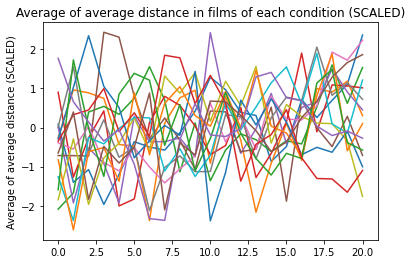

In [156]:
avg_avgs_scaled = TimeSeriesScalerMeanVariance().fit_transform(avg_avgs)
for avg_avg in avg_avgs_scaled:
    plt.plot(avg_avg)
plt.title(f"Average of average distance in films of each condition (SCALED)")
plt.ylabel("Average of average distance (SCALED)")

In [97]:
avg_deltas = []
for cond, films in dfs.items():
    df_all = []
    for film, df in films.items():
        df_max = df.apply(max, axis=1)
        df_min = df.apply(min, axis=1)
        df_delta = df_max - df_min
        df_all.append(df_delta)
    avg_deltas.append(to_time_series(pd.concat(df_all, axis=1).mean(axis=1)))
avg_deltas = np.array(avg_deltas)    

Text(0, 0.5, 'Average max-min distance difference')

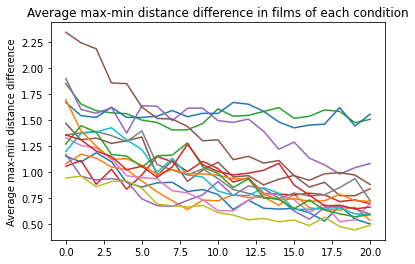

In [149]:
for avg_delta in avg_deltas:
    plt.plot(avg_delta)
plt.title(f"Average max-min distance difference in films of each condition")
plt.ylabel("Average max-min distance difference")

Text(0, 0.5, 'Average max-min distance difference (SCALED)')

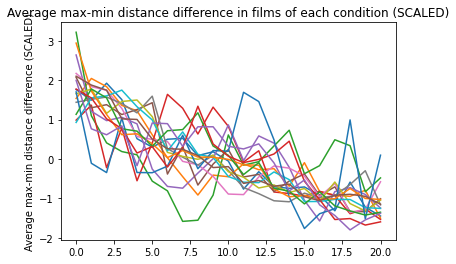

In [150]:
avg_deltas_scaled = TimeSeriesScalerMeanVariance().fit_transform(avg_deltas)
for avg_delta in avg_deltas_scaled:
    plt.plot(avg_delta)
plt.title(f"Average max-min distance difference in films of each condition (SCALED)")
plt.ylabel("Average max-min distance difference (SCALED)")

## Clustering scaled data
The clustering is done using the [k-means](https://en.wikipedia.org/wiki/K-means_clustering) method, where the computation of distance between to different curves is computed using three different methods:
- [Euclidean distance](https://en.wikipedia.org/wiki/Euclidean_distance) (in the case of time series: square root of sum of squared distance on each timestamp)
- [DTW Barycenter Averaging (DBA)](https://www.researchgate.net/publication/220601732_A_global_averaging_method_for_dynamic_time_warping_with_applications_to_clustering)
- [Soft-DTW](https://arxiv.org/abs/1703.01541)

In [159]:
n_cluster = 4

In [188]:
def cluster(X_train, n_cluster=n_cluster, seed=0):
    sz = X_train.shape[1]
    
    y_preds = {}

    # Euclidean k-means
    print("Euclidean k-means")
    km = TimeSeriesKMeans(n_clusters=n_cluster, verbose=True, random_state=seed)
    y_pred = km.fit_predict(X_train)
    y_preds["Euclidean k-means"] = y_pred

    plt.figure()
    for yi in range(n_cluster):
        plt.subplot(3, n_cluster, yi + 1)
        for xx in X_train[y_pred == yi]:
            plt.plot(xx.ravel(), "k-", alpha=.2)
        plt.plot(km.cluster_centers_[yi].ravel(), "r-")
        plt.xlim(0, sz)
        plt.ylim(-4, 4)
        plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
                 transform=plt.gca().transAxes)
        if yi == 1:
            plt.title("Euclidean $k$-means")

    # DBA-k-means
    print("DBA k-means")
    dba_km = TimeSeriesKMeans(n_clusters=n_cluster,
                              n_init=2,
                              metric="dtw",
                              verbose=True,
                              max_iter_barycenter=10,
                              random_state=seed)
    y_pred = dba_km.fit_predict(X_train)
    y_preds["DBA k-means"] = y_pred

    for yi in range(n_cluster):
        plt.subplot(3, n_cluster, n_cluster+1 + yi)
        for xx in X_train[y_pred == yi]:
            plt.plot(xx.ravel(), "k-", alpha=.2)
        plt.plot(dba_km.cluster_centers_[yi].ravel(), "r-")
        plt.xlim(0, sz)
        plt.ylim(-4, 4)
        plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
                 transform=plt.gca().transAxes)
        if yi == 1:
            plt.title("DBA $k$-means")

    # Soft-DTW-k-means
    print("Soft-DTW k-means")
    sdtw_km = TimeSeriesKMeans(n_clusters=n_cluster,
                               metric="softdtw",
                               metric_params={"gamma": .01},
                               verbose=True,
                               random_state=seed)
    y_pred = sdtw_km.fit_predict(X_train)
    y_preds["Soft-DTW k-means"] = y_pred

    for yi in range(n_cluster):
        plt.subplot(3, n_cluster, 2*n_cluster+1 + yi)
        for xx in X_train[y_pred == yi]:
            plt.plot(xx.ravel(), "k-", alpha=.2)
        plt.plot(sdtw_km.cluster_centers_[yi].ravel(), "r-")
        plt.xlim(0, sz)
        plt.ylim(-4, 4)
        plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
                 transform=plt.gca().transAxes)
        if yi == 1:
            plt.title("Soft-DTW $k$-means")

    plt.tight_layout()
    plt.show()

    return y_preds

### Max

Euclidean k-means
7.832 --> 5.554 --> 5.554 --> 
DBA k-means
Init 1
3.427 --> 2.326 --> 2.326 --> 
Init 2
3.250 --> 2.279 --> 2.279 --> 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  48 out of  48 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  48 out of  48 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  48 out of  48 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

Soft-DTW k-means
16.491 --> 4.849 --> 4.703 --> 4.698 --> 4.697 --> 4.698 --> 4.694 --> 4.694 --> 4.694 --> 4.694 --> 4.694 --> 4.694 --> 4.694 --> 4.694 --> 4.694 --> 4.694 --> 


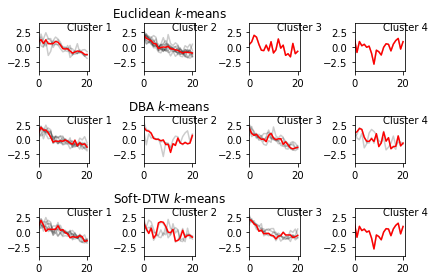

In [161]:
y_preds = cluster(avg_maxs_scaled)

In [172]:
for name, y_pred in y_preds.items():
    print('\n', name, '\n')
    for yi in range(n_cluster):
        print(f"==== Cluster {yi+1}:")
        for x in np.array(list(dfs.keys()))[y_pred == yi]:
            print(x)


 Euclidean k-means 

==== Cluster 1:
2_JDU233_him-10
7_JDU323_WT
8_JDU323_knl1
11_JDU574_WT
==== Cluster 2:
0_JDU233_WT_ex_utero
0_JDU233_WT_in_utero
3_JDU233_zwl-1
4_JDU233_him-10_zwl-1
5_JDU233_gei-17
6_JDU233_klp-19
10_JDU323_knl1_zwl1
12_JDU574_zwl1
13_JDU574_zwl1_him10
14_JDU574_zwl1_klp19
==== Cluster 3:
9_JDU323_knl1_him_10
==== Cluster 4:
1_JDU233_knl-1

 DBA k-means 

==== Cluster 1:
0_JDU233_WT_ex_utero
0_JDU233_WT_in_utero
4_JDU233_him-10_zwl-1
6_JDU233_klp-19
7_JDU323_WT
8_JDU323_knl1
14_JDU574_zwl1_klp19
==== Cluster 2:
1_JDU233_knl-1
5_JDU233_gei-17
==== Cluster 3:
3_JDU233_zwl-1
10_JDU323_knl1_zwl1
11_JDU574_WT
12_JDU574_zwl1
13_JDU574_zwl1_him10
==== Cluster 4:
2_JDU233_him-10
9_JDU323_knl1_him_10

 Soft-DTW k-means 

==== Cluster 1:
0_JDU233_WT_in_utero
4_JDU233_him-10_zwl-1
7_JDU323_WT
8_JDU323_knl1
11_JDU574_WT
12_JDU574_zwl1
13_JDU574_zwl1_him10
==== Cluster 2:
2_JDU233_him-10
3_JDU233_zwl-1
9_JDU323_knl1_him_10
==== Cluster 3:
0_JDU233_WT_ex_utero
5_JDU233_gei-17


Euclidean k-means


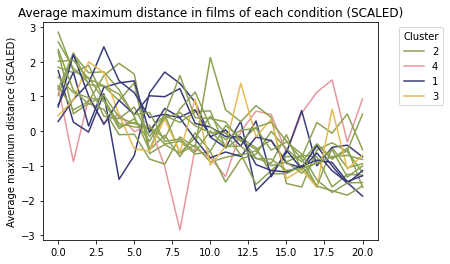

DBA k-means


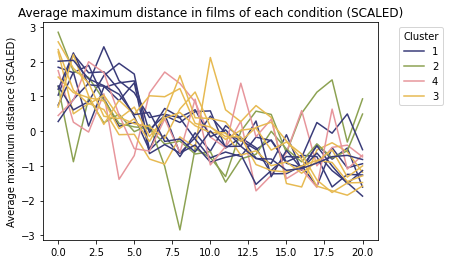

Soft-DTW k-means


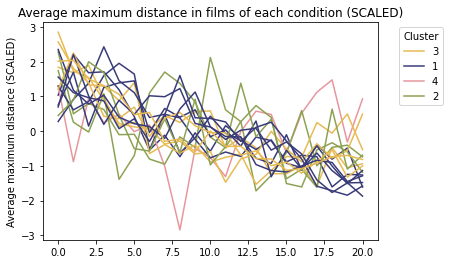

In [189]:
NUM_COLORS = n_cluster
cm = plt.get_cmap('tab20b')
for name, y_pred in y_preds.items():
    print(name)
    for avg_max, clus in zip(avg_maxs_scaled, y_pred):
        plt.plot(avg_max, label=clus+1, color=cm(1.*(clus)/NUM_COLORS))
    plt.title(f"Average maximum distance in films of each condition (SCALED)")
    plt.ylabel("Average maximum distance (SCALED)")
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(1.05, 1), loc='upper left', title="Cluster")
    plt.show()

### Min

Euclidean k-means
5.537 --> 3.157 --> 3.088 --> 3.088 --> 
DBA k-means
Init 1
1.952 --> 1.510 --> 1.510 --> 
Init 2
2.196 --> 1.460 --> 1.460 --> 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  48 out of  48 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  48 out of  48 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  48 out of  48 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

Soft-DTW k-means
5.978 --> 3.661 --> 3.657 --> 3.658 --> 3.671 --> 3.669 --> 3.670 --> 3.670 --> 3.670 --> 3.670 --> 3.670 --> 3.670 --> 3.670 --> 3.670 --> 


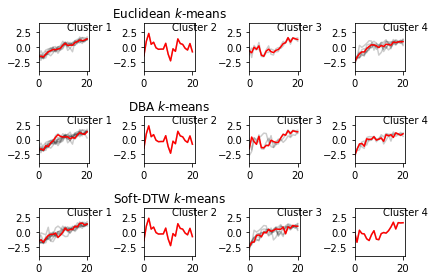

In [190]:
y_preds = cluster(avg_mins_scaled)

In [191]:
for name, y_pred in y_preds.items():
    print('\n', name, '\n')
    for yi in range(n_cluster):
        print(f"==== Cluster {yi+1}:")
        for x in np.array(list(dfs.keys()))[y_pred == yi]:
            print(x)


 Euclidean k-means 

==== Cluster 1:
0_JDU233_WT_ex_utero
5_JDU233_gei-17
6_JDU233_klp-19
8_JDU323_knl1
11_JDU574_WT
12_JDU574_zwl1
14_JDU574_zwl1_klp19
==== Cluster 2:
9_JDU323_knl1_him_10
==== Cluster 3:
2_JDU233_him-10
13_JDU574_zwl1_him10
==== Cluster 4:
0_JDU233_WT_in_utero
1_JDU233_knl-1
3_JDU233_zwl-1
4_JDU233_him-10_zwl-1
7_JDU323_WT
10_JDU323_knl1_zwl1

 DBA k-means 

==== Cluster 1:
0_JDU233_WT_ex_utero
0_JDU233_WT_in_utero
5_JDU233_gei-17
6_JDU233_klp-19
7_JDU323_WT
8_JDU323_knl1
11_JDU574_WT
12_JDU574_zwl1
14_JDU574_zwl1_klp19
==== Cluster 2:
9_JDU323_knl1_him_10
==== Cluster 3:
1_JDU233_knl-1
2_JDU233_him-10
13_JDU574_zwl1_him10
==== Cluster 4:
3_JDU233_zwl-1
4_JDU233_him-10_zwl-1
10_JDU323_knl1_zwl1

 Soft-DTW k-means 

==== Cluster 1:
0_JDU233_WT_ex_utero
0_JDU233_WT_in_utero
5_JDU233_gei-17
6_JDU233_klp-19
8_JDU323_knl1
11_JDU574_WT
13_JDU574_zwl1_him10
14_JDU574_zwl1_klp19
==== Cluster 2:
9_JDU323_knl1_him_10
==== Cluster 3:
1_JDU233_knl-1
3_JDU233_zwl-1
4_JDU233_him-

Euclidean k-means


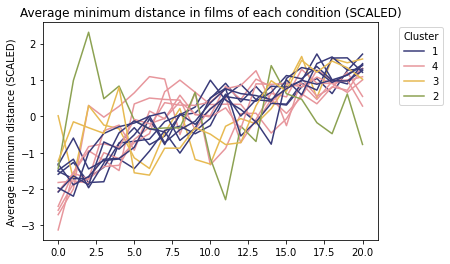

DBA k-means


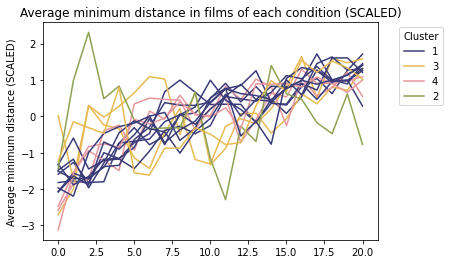

Soft-DTW k-means


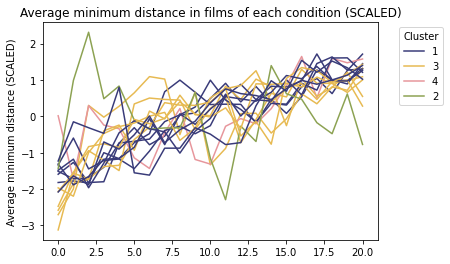

In [192]:
NUM_COLORS = n_cluster
cm = plt.get_cmap('tab20b')
for name, y_pred in y_preds.items():
    print(name)
    for avg_min, clus in zip(avg_mins_scaled, y_pred):
        plt.plot(avg_min, label=clus+1, color=cm(1.*(clus)/NUM_COLORS))
    plt.title(f"Average minimum distance in films of each condition (SCALED)")
    plt.ylabel("Average minimum distance (SCALED)")
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(1.05, 1), loc='upper left', title="Cluster")
    plt.show()

### Average

Euclidean k-means
20.697 --> 12.344 --> 12.344 --> 
DBA k-means
Init 1
7.468 --> 5.017 --> 5.017 --> 
Init 2
7.359 --> 4.849 --> 4.849 --> 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  48 out of  48 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  48 out of  48 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  48 out of  48 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

Soft-DTW k-means
82.320 --> 28.709 --> 28.680 --> 28.645 --> 28.640 --> 28.634 --> 28.633 --> 28.632 --> 28.632 --> 28.631 --> 28.631 --> 28.631 --> 28.631 --> 


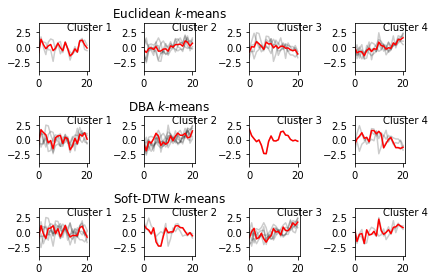

In [197]:
y_preds = cluster(avg_avgs_scaled)

In [198]:
for name, y_pred in y_preds.items():
    print('\n', name, '\n')
    for yi in range(n_cluster):
        print(f"==== Cluster {yi+1}:")
        for x in np.array(list(dfs.keys()))[y_pred == yi]:
            print(x)


 Euclidean k-means 

==== Cluster 1:
0_JDU233_WT_in_utero
11_JDU574_WT
==== Cluster 2:
1_JDU233_knl-1
6_JDU233_klp-19
8_JDU323_knl1
10_JDU323_knl1_zwl1
13_JDU574_zwl1_him10
==== Cluster 3:
4_JDU233_him-10_zwl-1
7_JDU323_WT
9_JDU323_knl1_him_10
12_JDU574_zwl1
==== Cluster 4:
0_JDU233_WT_ex_utero
2_JDU233_him-10
3_JDU233_zwl-1
5_JDU233_gei-17
14_JDU574_zwl1_klp19

 DBA k-means 

==== Cluster 1:
0_JDU233_WT_in_utero
2_JDU233_him-10
4_JDU233_him-10_zwl-1
6_JDU233_klp-19
11_JDU574_WT
==== Cluster 2:
0_JDU233_WT_ex_utero
1_JDU233_knl-1
3_JDU233_zwl-1
5_JDU233_gei-17
8_JDU323_knl1
10_JDU323_knl1_zwl1
14_JDU574_zwl1_klp19
==== Cluster 3:
13_JDU574_zwl1_him10
==== Cluster 4:
7_JDU323_WT
9_JDU323_knl1_him_10
12_JDU574_zwl1

 Soft-DTW k-means 

==== Cluster 1:
0_JDU233_WT_in_utero
4_JDU233_him-10_zwl-1
7_JDU323_WT
10_JDU323_knl1_zwl1
11_JDU574_WT
12_JDU574_zwl1
==== Cluster 2:
9_JDU323_knl1_him_10
13_JDU574_zwl1_him10
==== Cluster 3:
0_JDU233_WT_ex_utero
1_JDU233_knl-1
5_JDU233_gei-17
6_JDU233_k

Euclidean k-means


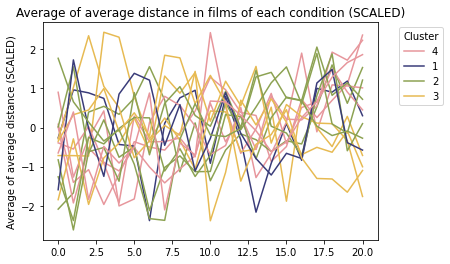

DBA k-means


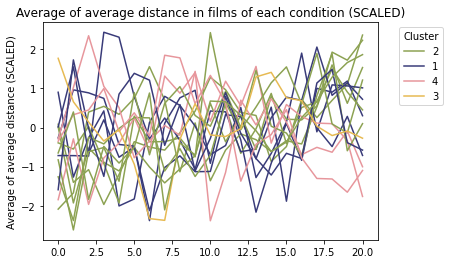

Soft-DTW k-means


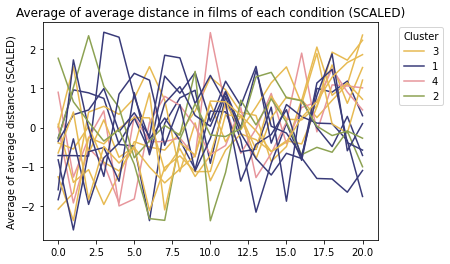

In [199]:
NUM_COLORS = n_cluster
cm = plt.get_cmap('tab20b')
for name, y_pred in y_preds.items():
    print(name)
    for avg_avg, clus in zip(avg_avgs_scaled, y_pred):
        plt.plot(avg_avg, label=clus+1, color=cm(1.*(clus)/NUM_COLORS))
    plt.title(f"Average of average distance in films of each condition (SCALED)")
    plt.ylabel("Average of average distance (SCALED)")
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(1.05, 1), loc='upper left', title="Cluster")
    plt.show()

### Max - min

Euclidean k-means
4.001 --> 2.413 --> 2.208 --> 2.208 --> 
DBA k-means
Init 1
1.614 --> 1.159 --> 1.159 --> 
Init 2
1.538 --> 1.059 --> 1.059 --> 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  48 out of  48 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  48 out of  48 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  48 out of  48 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

Soft-DTW k-means
4.199 --> 1.774 --> 1.772 --> 1.772 --> 1.771 --> 1.771 --> 1.771 --> 1.771 --> 1.771 --> 1.771 --> 1.771 --> 1.771 --> 1.771 --> 1.771 --> 


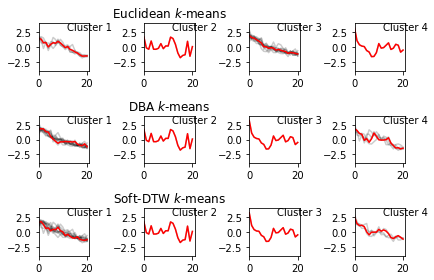

In [193]:
y_preds = cluster(avg_deltas_scaled)

In [194]:
for name, y_pred in y_preds.items():
    print('\n', name, '\n')
    for yi in range(n_cluster):
        print(f"==== Cluster {yi+1}:")
        for x in np.array(list(dfs.keys()))[y_pred == yi]:
            print(x)


 Euclidean k-means 

==== Cluster 1:
2_JDU233_him-10
11_JDU574_WT
12_JDU574_zwl1
13_JDU574_zwl1_him10
==== Cluster 2:
9_JDU323_knl1_him_10
==== Cluster 3:
0_JDU233_WT_ex_utero
0_JDU233_WT_in_utero
3_JDU233_zwl-1
4_JDU233_him-10_zwl-1
5_JDU233_gei-17
6_JDU233_klp-19
7_JDU323_WT
8_JDU323_knl1
10_JDU323_knl1_zwl1
14_JDU574_zwl1_klp19
==== Cluster 4:
1_JDU233_knl-1

 DBA k-means 

==== Cluster 1:
0_JDU233_WT_ex_utero
0_JDU233_WT_in_utero
4_JDU233_him-10_zwl-1
5_JDU233_gei-17
6_JDU233_klp-19
7_JDU323_WT
8_JDU323_knl1
10_JDU323_knl1_zwl1
11_JDU574_WT
14_JDU574_zwl1_klp19
==== Cluster 2:
9_JDU323_knl1_him_10
==== Cluster 3:
1_JDU233_knl-1
==== Cluster 4:
2_JDU233_him-10
3_JDU233_zwl-1
12_JDU574_zwl1
13_JDU574_zwl1_him10

 Soft-DTW k-means 

==== Cluster 1:
0_JDU233_WT_ex_utero
0_JDU233_WT_in_utero
2_JDU233_him-10
5_JDU233_gei-17
6_JDU233_klp-19
7_JDU323_WT
8_JDU323_knl1
11_JDU574_WT
12_JDU574_zwl1
13_JDU574_zwl1_him10
14_JDU574_zwl1_klp19
==== Cluster 2:
9_JDU323_knl1_him_10
==== Cluster 3:


Euclidean k-means


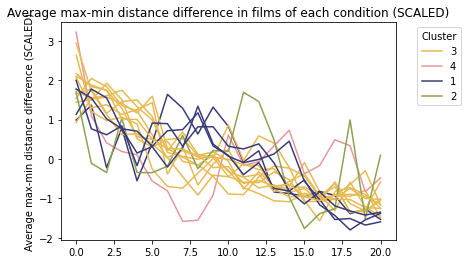

DBA k-means


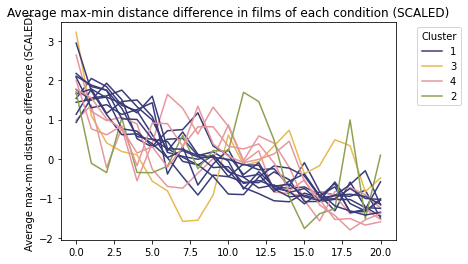

Soft-DTW k-means


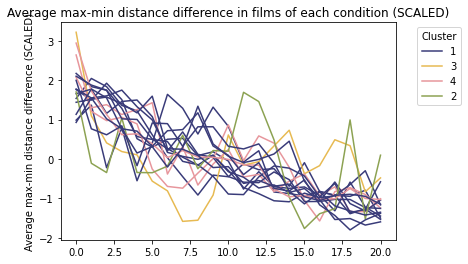

In [195]:
NUM_COLORS = n_cluster
cm = plt.get_cmap('tab20b')
for name, y_pred in y_preds.items():
    print(name)
    for avg_delta, clus in zip(avg_deltas_scaled, y_pred):
        plt.plot(avg_delta, label=clus+1, color=cm(1.*(clus)/NUM_COLORS))
    plt.title(f"Average max-min distance difference in films of each condition (SCALED)")
    plt.ylabel("Average max-min distance difference (SCALED)")
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(1.05, 1), loc='upper left', title="Cluster")
    plt.show()

## Clustering (amplitude-sensitive)

In [338]:
n_cluster = 3

### Max

Euclidean k-means
0.272 --> 0.145 --> 0.145 --> 
DBA k-means
Init 1
0.096 --> 0.063 --> 0.062 --> 0.062 --> 
Init 2
0.122 --> 0.068 --> 0.068 --> 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  48 out of  48 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  48 out of  48 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  48 out of  48 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  48 out of  48 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  48 out of  48 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

Soft-DTW k-means
0.018 --> 0.037 --> 0.037 --> 0.037 --> 0.037 --> 0.037 --> 


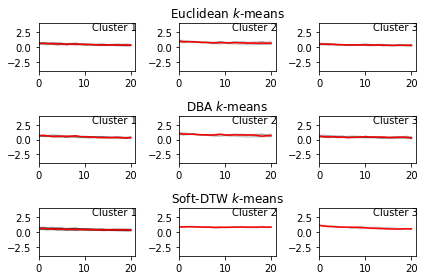

In [367]:
y_preds = cluster(avg_maxs, n_cluster=n_cluster)

In [368]:
for name, y_pred in y_preds.items():
    print('\n', name, '\n')
    for yi in range(n_cluster):
        print(f"==== Cluster {yi+1}:")
        for x in np.array(list(dfs.keys()))[y_pred == yi]:
            print(x)


 Euclidean k-means 

==== Cluster 1:
2_JDU233_him-10
4_JDU233_him-10_zwl-1
6_JDU233_klp-19
8_JDU323_knl1
10_JDU323_knl1_zwl1
11_JDU574_WT
12_JDU574_zwl1
==== Cluster 2:
1_JDU233_knl-1
9_JDU323_knl1_him_10
13_JDU574_zwl1_him10
14_JDU574_zwl1_klp19
==== Cluster 3:
0_JDU233_WT_ex_utero
0_JDU233_WT_in_utero
3_JDU233_zwl-1
5_JDU233_gei-17
7_JDU323_WT

 DBA k-means 

==== Cluster 1:
4_JDU233_him-10_zwl-1
5_JDU233_gei-17
8_JDU323_knl1
10_JDU323_knl1_zwl1
11_JDU574_WT
12_JDU574_zwl1
==== Cluster 2:
1_JDU233_knl-1
9_JDU323_knl1_him_10
13_JDU574_zwl1_him10
14_JDU574_zwl1_klp19
==== Cluster 3:
0_JDU233_WT_ex_utero
0_JDU233_WT_in_utero
2_JDU233_him-10
3_JDU233_zwl-1
6_JDU233_klp-19
7_JDU323_WT

 Soft-DTW k-means 

==== Cluster 1:
0_JDU233_WT_ex_utero
0_JDU233_WT_in_utero
2_JDU233_him-10
3_JDU233_zwl-1
4_JDU233_him-10_zwl-1
5_JDU233_gei-17
6_JDU233_klp-19
7_JDU323_WT
8_JDU323_knl1
10_JDU323_knl1_zwl1
11_JDU574_WT
12_JDU574_zwl1
==== Cluster 2:
1_JDU233_knl-1
9_JDU323_knl1_him_10
==== Cluster 3:
13

In [369]:
NUM_COLORS = n_cluster
cm = plt.get_cmap('tab20b')
for name, y_pred in y_preds.items():
    print(name)
    for avg_max, clus in zip(avg_maxs, y_pred):
        plt.plot(avg_max, label=clus+, color=cm(1.*(clus)/NUM_COLORS))
    plt.title(f"Average maximum distance in films of each condition")
    plt.ylabel("Average maximum distance")
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(1.05, 1), loc='upper left', title="Cluster")
    plt.show()

SyntaxError: invalid syntax (<ipython-input-369-f85dddfdc141>, line 6)

### Min

Euclidean k-means
0.241 --> 0.149 --> 0.149 --> 
DBA k-means
Init 1
0.081 --> 0.058 --> 0.058 --> 
Init 2
0.088 --> 0.054 --> 0.054 --> 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  48 out of  48 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  48 out of  48 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  48 out of  48 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  48 out of  48 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  48 out of  48 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

Soft-DTW k-means
0.019 --> 0.034 --> 0.034 --> 0.034 --> 0.034 --> 0.034 --> 0.034 --> 0.034 --> 


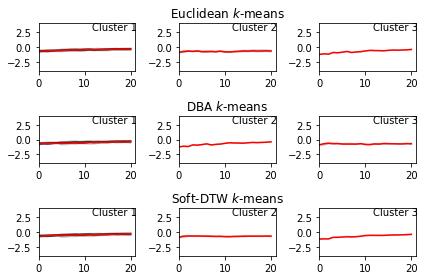

In [358]:
y_preds = cluster(avg_mins, n_cluster=n_cluster)

In [359]:
for name, y_pred in y_preds.items():
    print('\n', name, '\n')
    for yi in range(n_cluster):
        print(f"==== Cluster {yi+1}:")
        for x in np.array(list(dfs.keys()))[y_pred == yi]:
            print(x)


 Euclidean k-means 

==== Cluster 1:
0_JDU233_WT_ex_utero
0_JDU233_WT_in_utero
2_JDU233_him-10
3_JDU233_zwl-1
4_JDU233_him-10_zwl-1
5_JDU233_gei-17
6_JDU233_klp-19
7_JDU323_WT
8_JDU323_knl1
10_JDU323_knl1_zwl1
11_JDU574_WT
12_JDU574_zwl1
==== Cluster 2:
1_JDU233_knl-1
9_JDU323_knl1_him_10
13_JDU574_zwl1_him10
==== Cluster 3:
14_JDU574_zwl1_klp19

 DBA k-means 

==== Cluster 1:
0_JDU233_WT_ex_utero
0_JDU233_WT_in_utero
2_JDU233_him-10
3_JDU233_zwl-1
4_JDU233_him-10_zwl-1
5_JDU233_gei-17
6_JDU233_klp-19
7_JDU323_WT
8_JDU323_knl1
10_JDU323_knl1_zwl1
11_JDU574_WT
12_JDU574_zwl1
13_JDU574_zwl1_him10
==== Cluster 2:
14_JDU574_zwl1_klp19
==== Cluster 3:
1_JDU233_knl-1
9_JDU323_knl1_him_10

 Soft-DTW k-means 

==== Cluster 1:
0_JDU233_WT_ex_utero
0_JDU233_WT_in_utero
2_JDU233_him-10
3_JDU233_zwl-1
4_JDU233_him-10_zwl-1
5_JDU233_gei-17
6_JDU233_klp-19
7_JDU323_WT
8_JDU323_knl1
10_JDU323_knl1_zwl1
11_JDU574_WT
12_JDU574_zwl1
13_JDU574_zwl1_him10
==== Cluster 2:
1_JDU233_knl-1
9_JDU323_knl1_him_

Euclidean k-means


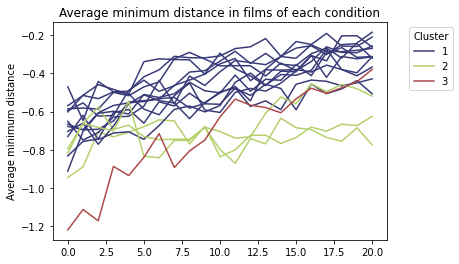

DBA k-means


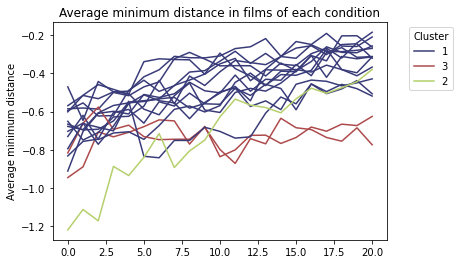

Soft-DTW k-means


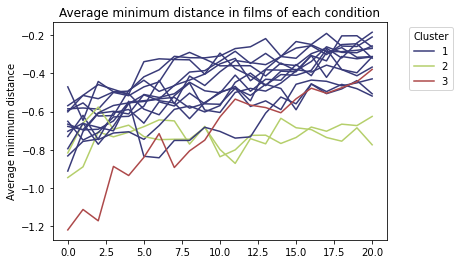

In [360]:
NUM_COLORS = n_cluster
cm = plt.get_cmap('tab20b')
for name, y_pred in y_preds.items():
    print(name)
    for avg_min, clus in zip(avg_mins, y_pred):
        plt.plot(avg_min, label=clus+1, color=cm(1.*(clus)/NUM_COLORS))
    plt.title(f"Average minimum distance in films of each condition")
    plt.ylabel("Average minimum distance")
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(1.05, 1), loc='upper left', title="Cluster")
    plt.show()

### Average

Euclidean k-means
0.060 --> 0.034 --> 0.032 --> 0.032 --> 
DBA k-means
Init 1
0.024 --> 0.015 --> 0.015 --> 0.015 --> 
Init 2
0.024 --> 0.016 --> 0.016 --> 0.016 --> 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  48 out of  48 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  48 out of  48 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  48 out of  48 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  48 out of  48 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  48 out of  48 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j

Soft-DTW k-means
0.055 --> 0.077 --> 0.077 --> 0.077 --> 0.077 --> 


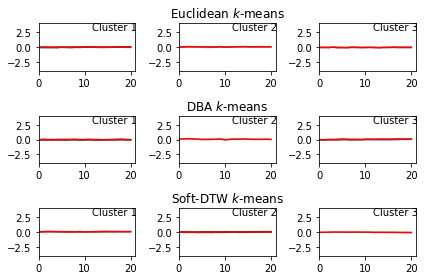

In [361]:
y_preds = cluster(avg_avgs, n_cluster=n_cluster)

In [362]:
for name, y_pred in y_preds.items():
    print('\n', name, '\n')
    for yi in range(n_cluster):
        print(f"==== Cluster {yi+1}:")
        for x in np.array(list(dfs.keys()))[y_pred == yi]:
            print(x)


 Euclidean k-means 

==== Cluster 1:
0_JDU233_WT_ex_utero
0_JDU233_WT_in_utero
3_JDU233_zwl-1
5_JDU233_gei-17
7_JDU323_WT
10_JDU323_knl1_zwl1
11_JDU574_WT
14_JDU574_zwl1_klp19
==== Cluster 2:
1_JDU233_knl-1
8_JDU323_knl1
9_JDU323_knl1_him_10
13_JDU574_zwl1_him10
==== Cluster 3:
2_JDU233_him-10
4_JDU233_him-10_zwl-1
6_JDU233_klp-19
12_JDU574_zwl1

 DBA k-means 

==== Cluster 1:
0_JDU233_WT_in_utero
2_JDU233_him-10
4_JDU233_him-10_zwl-1
6_JDU233_klp-19
7_JDU323_WT
10_JDU323_knl1_zwl1
11_JDU574_WT
12_JDU574_zwl1
==== Cluster 2:
9_JDU323_knl1_him_10
13_JDU574_zwl1_him10
==== Cluster 3:
0_JDU233_WT_ex_utero
1_JDU233_knl-1
3_JDU233_zwl-1
5_JDU233_gei-17
8_JDU323_knl1
14_JDU574_zwl1_klp19

 Soft-DTW k-means 

==== Cluster 1:
0_JDU233_WT_in_utero
1_JDU233_knl-1
8_JDU323_knl1
9_JDU323_knl1_him_10
13_JDU574_zwl1_him10
==== Cluster 2:
0_JDU233_WT_ex_utero
2_JDU233_him-10
3_JDU233_zwl-1
5_JDU233_gei-17
6_JDU233_klp-19
7_JDU323_WT
10_JDU323_knl1_zwl1
11_JDU574_WT
14_JDU574_zwl1_klp19
==== Cluster 

Euclidean k-means


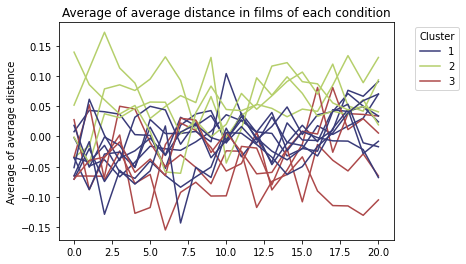

DBA k-means


Soft-DTW k-means


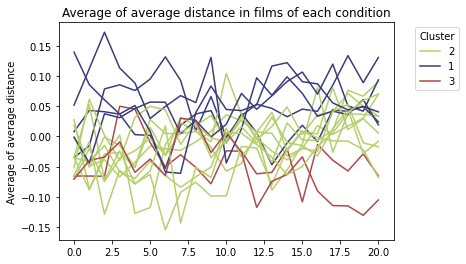

In [363]:
NUM_COLORS = n_cluster
cm = plt.get_cmap('tab20b')
for name, y_pred in y_preds.items():
    print(name)
    for avg_avg, clus in zip(avg_avgs, y_pred):
        plt.plot(avg_avg, label=clus+1, color=cm(1.*(clus)/NUM_COLORS))
    plt.title(f"Average of average distance in films of each condition")
    plt.ylabel("Average of average distance")
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(1.05, 1), loc='upper left', title="Cluster")
    plt.show()

### Max - min

Euclidean k-means
0.940 --> 0.551 --> 0.551 --> 
DBA k-means
Init 1
0.355 --> 0.194 --> 0.194 --> 
Init 2
1.114 --> 0.355 --> 0.256 --> 0.213 --> 0.172 --> 0.172 --> 
Soft-DTW k-means

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  32 out of  32 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  16 out of  16 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_j


0.694 --> 0.113 --> 0.021 --> 0.021 --> 0.021 --> 0.021 --> 0.021 --> 0.021 --> 0.021 --> 0.021 --> 0.021 --> 0.021 --> 0.021 --> 0.021 --> 0.021 --> 0.021 --> 0.021 --> 0.021 --> 0.021 --> 0.021 --> 0.021 --> 0.021 --> 0.021 --> 0.021 --> 0.021 --> 0.021 --> 0.021 --> 0.021 --> 0.021 --> 0.021 --> 0.021 --> 0.021 --> 0.021 --> 


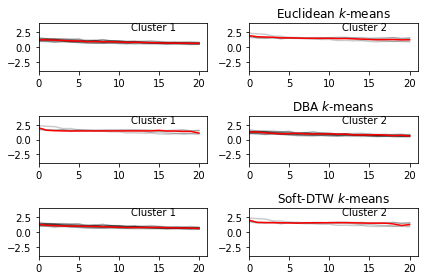

In [370]:
n_cluster = 2
y_preds = cluster(avg_deltas, n_cluster=n_cluster)

In [371]:
for name, y_pred in y_preds.items():
    print('\n', name, '\n')
    for yi in range(n_cluster):
        print(f"==== Cluster {yi+1}:")
        for x in np.array(list(dfs.keys()))[y_pred == yi]:
            print(x)


 Euclidean k-means 

==== Cluster 1:
0_JDU233_WT_ex_utero
0_JDU233_WT_in_utero
2_JDU233_him-10
3_JDU233_zwl-1
4_JDU233_him-10_zwl-1
5_JDU233_gei-17
6_JDU233_klp-19
7_JDU323_WT
8_JDU323_knl1
10_JDU323_knl1_zwl1
11_JDU574_WT
12_JDU574_zwl1
==== Cluster 2:
1_JDU233_knl-1
9_JDU323_knl1_him_10
13_JDU574_zwl1_him10
14_JDU574_zwl1_klp19

 DBA k-means 

==== Cluster 1:
1_JDU233_knl-1
9_JDU323_knl1_him_10
13_JDU574_zwl1_him10
14_JDU574_zwl1_klp19
==== Cluster 2:
0_JDU233_WT_ex_utero
0_JDU233_WT_in_utero
2_JDU233_him-10
3_JDU233_zwl-1
4_JDU233_him-10_zwl-1
5_JDU233_gei-17
6_JDU233_klp-19
7_JDU323_WT
8_JDU323_knl1
10_JDU323_knl1_zwl1
11_JDU574_WT
12_JDU574_zwl1

 Soft-DTW k-means 

==== Cluster 1:
0_JDU233_WT_ex_utero
0_JDU233_WT_in_utero
2_JDU233_him-10
3_JDU233_zwl-1
4_JDU233_him-10_zwl-1
5_JDU233_gei-17
6_JDU233_klp-19
7_JDU323_WT
8_JDU323_knl1
10_JDU323_knl1_zwl1
11_JDU574_WT
12_JDU574_zwl1
==== Cluster 2:
1_JDU233_knl-1
9_JDU323_knl1_him_10
13_JDU574_zwl1_him10
14_JDU574_zwl1_klp19


Euclidean k-means


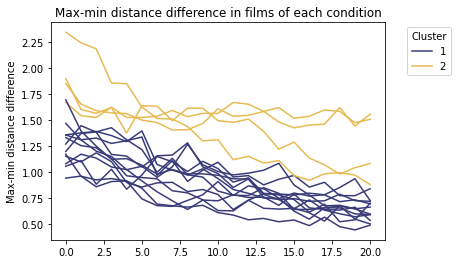

DBA k-means


Soft-DTW k-means


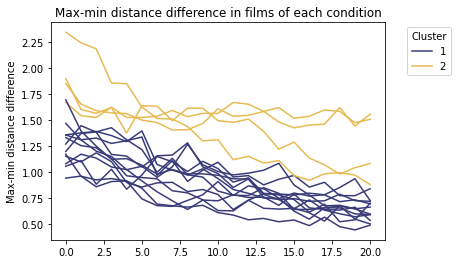

In [372]:
NUM_COLORS = n_cluster
cm = plt.get_cmap('tab20b')
for name, y_pred in y_preds.items():
    print(name)
    for avg_delta, clus in zip(avg_deltas, y_pred):
        plt.plot(avg_delta, label=clus+1, color=cm(1.*(clus)/NUM_COLORS))
    plt.title(f"Max-min distance difference in films of each condition")
    plt.ylabel("Max-min distance difference")
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    plt.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(1.05, 1), loc='upper left', title="Cluster")
    plt.show()

# Peaks and valleys 
Here we want to compute the number of peaks and the number of valleys (defined as [local maxima and minima](https://en.wikipedia.org/wiki/Maxima_and_minima), respectively) for each chromosomes. 

In [204]:
def extract_peaks_valleys(series):
    peaks_idx = []
    valleys_idx = []
    for i in range(1, len(series)-1):
        if series[i] > series[i-1] and series[i] > series[i+1]:
            peaks_idx.append(i)
        elif series[i] < series[i-1] and series[i] < series[i+1]:
            valleys_idx.append(i)
    return peaks_idx, valleys_idx

For example, we see below **each dotted line** represents the distances of one chromosome in `191122_01` film from condition `9_JDU323_knl1_him_10`, and the **red dots** are the peaks, while the **blue dots** are the valleys.

Automatic pdb calling has been turned ON


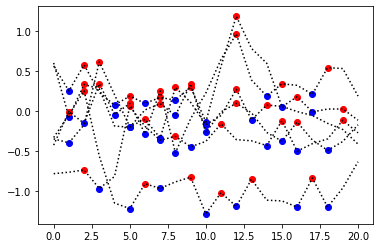

In [222]:
%pdb 1
cond = "9_JDU323_knl1_him_10"
film = "191122_01"
df = dfs[cond][film]
for col in df.columns:
    df_col = df[col]
    df_col = list(df_col)
    peaks_idx, valleys_idx = extract_peaks_valleys(df_col)
    plt.plot(df_col, linestyle=':', color="black", label=col)
    plt.scatter(peaks_idx, np.array(df_col)[peaks_idx], color="red")
    plt.scatter(valleys_idx, np.array(df_col)[valleys_idx], color="blue")    

## Number of peaks/valleys

Now, for each of the chromosome, in each film & condition, we compute the number of peaks and valleys.

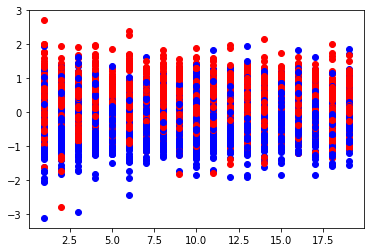

In [227]:
peaks_valleys = {}
for cond, films in dfs.items():
    peaks_valleys[cond] = {}
    for film, df in films.items():
        nb_peaks = []
        nb_valleys = []
        for col in df.columns:
            df_col = df[col]
            df_col = list(df_col)
            peaks_idx, valleys_idx = extract_peaks_valleys(df_col)
            nb_peaks.append(len(peaks_idx))
            nb_valleys.append(len(valleys_idx))
#             plt.plot(df_col, linestyle=':', color="black", label=col)
#             plt.scatter(peaks_idx, np.array(df_col)[peaks_idx], color="red")
#             plt.scatter(valleys_idx, np.array(df_col)[valleys_idx], color="blue")    
        peaks_valleys[cond][film] = {
            "nb_peaks": nb_peaks,
            "nb_valleys": nb_valleys
        }

In [229]:
from collections import defaultdict
df_pv = defaultdict(list)
for cond, films in peaks_valleys.items():
    for film, pv_dict in films.items():
        df_pv["condition"].append(cond)
        df_pv["film"].append(film)
        for i in range(6):
            df_pv[f"nb_peaks_{i}"].append(pv_dict["nb_peaks"][i])
            df_pv[f"nb_valleys_{i}"].append(pv_dict["nb_valleys"][i])
df_pv = pd.DataFrame(df_pv)            

In [230]:
len(df_pv)

251

In [231]:
df_pv.head()

condition        film  nb_peaks_0  nb_valleys_0  nb_peaks_1  \
0  0_JDU233_WT_ex_utero  191011_03B           5             6           6   
1  0_JDU233_WT_ex_utero  191011_07B           5             4           6   
2  0_JDU233_WT_ex_utero  191011_08B           6             7           7   
3  0_JDU233_WT_ex_utero   191011_09           4             4           7   
4  0_JDU233_WT_ex_utero   191011_11           5             6           5   

   nb_valleys_1  nb_peaks_2  nb_valleys_2  nb_peaks_3  nb_valleys_3  \
0             6           7             7           7             7   
1             6           7             7           5             5   
2             8           5             6           6             7   
3             7           6             6           5             5   
4             6           7             7           7             8   

   nb_peaks_4  nb_valleys_4  nb_peaks_5  nb_valleys_5  
0           5             5           6             6  
1           5             5           5             5  
2           6             7           5             6  
3           5             4           4             5  
4           4             5           6             7

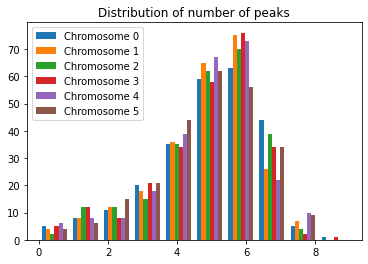

In [239]:
plt.hist(df_pv[[f"nb_peaks_{i}" for i in range(6)]])
plt.title("Distribution of number of peaks")
plt.legend([f"Chromosome {i}" for i in range(6)])

In [240]:
plt.hist(df_pv[[f"nb_valleys_{i}" for i in range(6)]])
plt.title("Distribution of number of valleys")
plt.legend([f"Chromosome {i}" for i in range(6)])

## Time steps between peaks/ between valleys
Now we want to note the time-steps between **two _consecutive_ peaks** or **two _consecutive_ valleys**. For example, if the first peak occurs at timestamp 0 and the second one at timestamp 2, then the time step between the two peaks is 2.

In [241]:
peaks_valleys = {}
for cond, films in dfs.items():
    peaks_valleys[cond] = {}
    for film, df in films.items():
        peaks = []
        valleys = []
        for col in df.columns:
            df_col = df[col]
            df_col = list(df_col)
            peaks_idx, valleys_idx = extract_peaks_valleys(df_col)
            peaks.append(peaks_idx)
            valleys.append(valleys_idx)
        peaks_valleys[cond][film] = {
            "peaks_idxs": peaks,
            "valleys_idxs": valleys
        }

In [264]:
peak_rows = []
valley_rows = []
count = 0
for cond, films in peaks_valleys.items():
    for film, pv_dict in films.items():
        for i in range(6):
            peak_rows.append(pd.Series([cond, film, str(i)] + [str(x) for x in pv_dict["peaks_idxs"][i]]))
            valley_rows.append(pd.Series([cond, film, str(i)] + [str(x) for x in pv_dict["valleys_idxs"][i]]))
            count += 1

In [259]:
df_peaks = pd.concat(peak_rows, axis=1).transpose()
df_valleys = pd.concat(valley_rows, axis=1).transpose()

In [272]:
df_peaks.head()

0           1  2  3  4   5   6   7    8    9    10   11
0  0_JDU233_WT_ex_utero  191011_03B  0  4  8  11  15  17  NaN  NaN  NaN  NaN
1  0_JDU233_WT_ex_utero  191011_03B  1  1  5   7   9  13   16  NaN  NaN  NaN
2  0_JDU233_WT_ex_utero  191011_03B  2  3  5   8  11  14   17   19  NaN  NaN
3  0_JDU233_WT_ex_utero  191011_03B  3  2  5   7   9  13   16   18  NaN  NaN
4  0_JDU233_WT_ex_utero  191011_03B  4  2  5  13  16  18  NaN  NaN  NaN  NaN

In [286]:
df_peaks.columns = ["Condition", "Film", "Chromosome"] + [f"Peak {i+1}" for i in range(len(df_peaks.columns)-3)]
df_valleys.columns = ["Condition", "Film", "Chromosome"] + [f"Valley {i+1}" for i in range(len(df_valleys.columns)-3)]

In [287]:
df_peaks.head()

Condition        Film Chromosome Peak 1 Peak 2 Peak 3 Peak 4  \
0  0_JDU233_WT_ex_utero  191011_03B          0      4      8     11     15   
1  0_JDU233_WT_ex_utero  191011_03B          1      1      5      7      9   
2  0_JDU233_WT_ex_utero  191011_03B          2      3      5      8     11   
3  0_JDU233_WT_ex_utero  191011_03B          3      2      5      7      9   
4  0_JDU233_WT_ex_utero  191011_03B          4      2      5     13     16   

  Peak 5 Peak 6 Peak 7 Peak 8 Peak 9  
0     17    NaN    NaN    NaN    NaN  
1     13     16    NaN    NaN    NaN  
2     14     17     19    NaN    NaN  
3     13     16     18    NaN    NaN  
4     18    NaN    NaN    NaN    NaN

In [288]:
df_peaks.to_csv("location_of_peaks.csv")
df_valleys.to_csv("location_of_valleys.csv")

In [279]:
diff_dict = {}
for cond, films in peaks_valleys.items():
    diff_dict[cond] = {}
    for film, pv_dict in films.items():
        peaks_diff_list = []
        valleys_diff_list = []
        for i in range(6):
            peaks_idxs = pv_dict["peaks_idxs"][i]
            valleys_idxs = pv_dict["valleys_idxs"][i]
            peaks_diff = [x - peaks_idxs[i - 1] for i, x in enumerate(peaks_idxs)][1:]
            valleys_diff = [x - valleys_idxs[i - 1] for i, x in enumerate(valleys_idxs)][1:]
            peaks_diff_list.append(peaks_diff)
            valleys_diff_list.append(valleys_diff)
        diff_dict[cond][film] = {
            "peaks_diff": peaks_diff_list,
            "valleys_diff": valleys_diff_list
        }

In [280]:
peak_diff_rows = []
valley_diff_rows = []
for cond, films in diff_dict.items():
    for film, pv_dict in films.items():
        for i in range(6):
            peak_diff = pv_dict["peaks_diff"][i]
            valley_diff = pv_dict["valleys_diff"][i]
            peak_diff_rows.append(pd.Series([cond, film, str(i)] + [str(x) for x in peak_diff]))
            valley_diff_rows.append(pd.Series([cond, film, str(i)] + [str(x) for x in valley_diff]))

Automatic pdb calling has been turned OFF


In [281]:
df_peaks_diff = pd.concat(peak_diff_rows, axis=1).transpose()
df_valleys_diff = pd.concat(valley_diff_rows, axis=1).transpose()

In [289]:
df_peaks_diff.columns = ["Condition", "Film", "Chromosome"] + [f"Peaks Distance {i+1}" for i in range(len(df_peaks_diff.columns)-3)]
df_valleys_diff.columns = ["Condition", "Film", "Chromosome"] + [f"Valleys Distance {i+1}" for i in range(len(df_valleys_diff.columns)-3)]

In [290]:
df_peaks_diff.head()

Condition        Film Chromosome Peaks Distance 1  \
0  0_JDU233_WT_ex_utero  191011_03B          0                4   
1  0_JDU233_WT_ex_utero  191011_03B          1                4   
2  0_JDU233_WT_ex_utero  191011_03B          2                2   
3  0_JDU233_WT_ex_utero  191011_03B          3                3   
4  0_JDU233_WT_ex_utero  191011_03B          4                3   

  Peaks Distance 2 Peaks Distance 3 Peaks Distance 4 Peaks Distance 5  \
0                3                4                2              NaN   
1                2                2                4                3   
2                3                3                3                3   
3                2                2                4                3   
4                8                3                2              NaN   

  Peaks Distance 6 Peaks Distance 7 Peaks Distance 8  
0              NaN              NaN              NaN  
1              NaN              NaN              NaN  
2                2              NaN              NaN  
3                2              NaN              NaN  
4              NaN              NaN              NaN

In [291]:
df_peaks_diff.to_csv("peaks_distance.csv")
df_valleys_diff.to_csv("valleys_distance.csv")

In [292]:
len(df_peaks_diff)

1506

In [293]:
len(df_valleys_diff)

1506

# Negative/positive oscillation
Here we just want to note whether the chromosome oscilates only in the positive pole, negative pole, or oscillatets between them

In [306]:
oscillations = {}
for cond, films in dfs.items():
    oscillations[cond] = {}
    for film, df in films.items():
        nb_positives = 0
        nb_negatives = 0
        nb_both = 0
        for col in df.columns:
            if len(np.where(np.array(list(df[col])) >= 0)[0]) == len(df[col]):
                nb_positives += 1
            elif len(np.where(np.array(list(df[col])) <= 0)[0]) == len(df[col]):
                nb_negatives += 1
            else:
                nb_both += 1
        assert((nb_positives + nb_negatives + nb_both) == 6)
        oscillations[cond][film] = {
            "nb_pos": nb_positives,
            "nb_neg": nb_negatives,
            "nb_both": nb_both
        }

In [309]:
cond_list = []
film_list = []
nb_pos_list = []
nb_neg_list = []
nb_both_list = []
for cond, films in oscillations.items():
    for film, nb_dict in films.items():
        cond_list.append(cond)
        film_list.append(film)
        nb_pos_list.append(nb_dict["nb_pos"])
        nb_neg_list.append(nb_dict["nb_neg"])
        nb_both_list.append(nb_dict["nb_both"])
df_osc = pd.DataFrame({
    "Condition": cond_list,
    "Film": film_list,
    "#Chromosomes moving in + only": nb_pos_list,
    "#Chromosomes moving in - only": nb_neg_list,
    "#Chromosomes moving in + & -": nb_both_list,
})        

In [310]:
len(df_osc)

251

In [311]:
df_osc.head()

Condition        Film  #Chromosomes moving in + only  \
0  0_JDU233_WT_ex_utero  191011_03B                              0   
1  0_JDU233_WT_ex_utero  191011_07B                              0   
2  0_JDU233_WT_ex_utero  191011_08B                              0   
3  0_JDU233_WT_ex_utero   191011_09                              0   
4  0_JDU233_WT_ex_utero   191011_11                              2   

   #Chromosomes moving in - only  #Chromosomes moving in + & -  
0                              0                             6  
1                              1                             5  
2                              0                             6  
3                              0                             6  
4                              0                             4

In [328]:
df_osc[df_osc.columns[-3:]].sum(axis=0)

#Chromosomes moving in + only      48
#Chromosomes moving in - only      49
#Chromosomes moving in + & -     1409
dtype: int64

In [329]:
df_osc[df_osc.columns[-3:]].sum(axis=0).sum()

1506

In [316]:
df_osc.to_csv("pos_neg_oscillation.csv")

# Trailing Moving Average
The value at time (t) is calculated as the average of the raw observations at and before the time (t).

For example, a trailing moving average with a window of 3 would be calculated as:
trail_ma(t) = mean(obs(t-2), obs(t-1), obs(t))

Trailing moving average only uses historical observations and is used on time series forecasting.

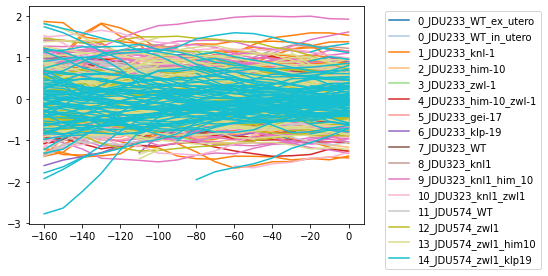

In [389]:
NUM_COLORS = len(dfs.keys())
cm = plt.get_cmap('tab20')
for cond_id, (cond, films) in enumerate(dfs.items()):
    for film, df in films.items():
        for i in range(6):
            plt.plot(df.iloc[:,i].rolling(window=5).mean(), label=cond, color=cm(1.*cond_id/NUM_COLORS))
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(1.05, 1), loc='upper left')

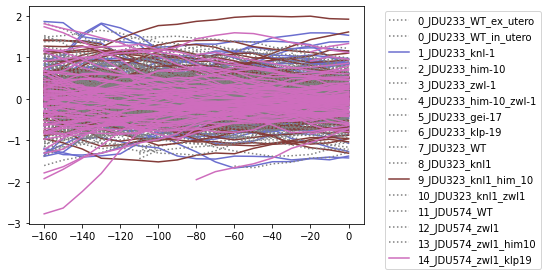

In [399]:
NUM_COLORS = len(dfs.keys())
cm = plt.get_cmap('tab20b')
for cond_id, (cond, films) in enumerate(dfs.items()):
    for film, df in films.items():
        for i in range(6):
            if cond_id in [2, 10, 15]:
                plt.plot(df.iloc[:,i].rolling(window=5).mean(), label=cond, color=cm(1.*cond_id/NUM_COLORS))
            else: 
                plt.plot(df.iloc[:,i].rolling(window=5).mean(), label=cond, color="grey", linestyle=":")
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(1.05, 1), loc='upper left')

# Trailing Moving Std. Deviation

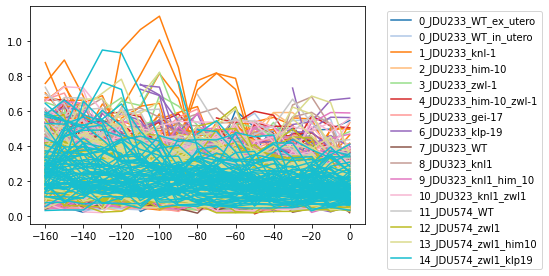

In [390]:
for cond_id, (cond, films) in enumerate(dfs.items()):
    for film, df in films.items():
        for i in range(6):
            plt.plot(df.iloc[:,i].rolling(window=5).std(), label=cond, color=cm(1.*cond_id/NUM_COLORS))
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(1.05, 1), loc='upper left')

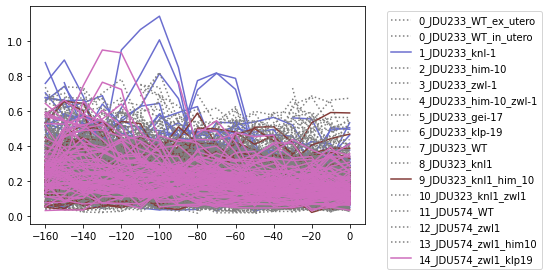

In [400]:
NUM_COLORS = len(dfs.keys())
cm = plt.get_cmap('tab20b')
for cond_id, (cond, films) in enumerate(dfs.items()):
    for film, df in films.items():
        for i in range(6):
            if cond_id in [2, 10, 15]:
                plt.plot(df.iloc[:,i].rolling(window=5).std(), label=cond, color=cm(1.*cond_id/NUM_COLORS))
            else: 
                plt.plot(df.iloc[:,i].rolling(window=5).std(), label=cond, color="grey", linestyle=":")
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(1.05, 1), loc='upper left')

# Entropy

In [7]:
from entropy import *
import numpy as np
np.random.seed(1234567)
x = np.random.rand(3000)
print(perm_entropy(x, order=3, normalize=True))                 # Permutation entropy
print(spectral_entropy(x, 100, method='welch', normalize=True)) # Spectral entropy
print(svd_entropy(x, order=3, delay=1, normalize=True))         # Singular value decomposition entropy
print(app_entropy(x, order=2, metric='chebyshev'))              # Approximate entropy
print(sample_entropy(x, order=2, metric='chebyshev'))           # Sample entropy
print(lziv_complexity('01111000011001', normalize=True))        # Lempel-Ziv complexity

0.9995858289645746
0.9945519071575192
0.8482185855709181
2.076046899582793
2.192416747827227
1.3597696150205727


In [8]:
from collections import defaultdict
df_entropy = defaultdict(list)
for cond, films in dfs.items():
    for film, df in films.items():
        if not df.isnull().values.any():
            df_entropy["condition"].append(cond)
            df_entropy["film"].append(film)
            for i in range(6):
                df_entropy[i].append(app_entropy(list(df.iloc[:,i]), order=2, metric='chebyshev'))

In [9]:
df_entropy = pd.DataFrame(df_entropy)

In [10]:
df_entropy.head()

condition        film         0         1         2         3  \
0  0_JDU233_WT_ex_utero  191011_03B  0.087336 -0.051293  0.080040  0.087336   
1  0_JDU233_WT_ex_utero  191011_07B  0.228207  0.018021  0.018021  0.156651   
2  0_JDU233_WT_ex_utero  191011_08B -0.051293  0.106202 -0.051293  0.018021   
3  0_JDU233_WT_ex_utero   191011_09  0.156651  0.010725  0.087336  0.211581   
4  0_JDU233_WT_ex_utero   191011_11 -0.051293  0.270994  0.156651  0.156651   

          4         5  
0  0.211581  0.156651  
1  0.018021  0.124235  
2 -0.051293  0.246916  
3  0.018021  0.069304  
4  0.018021  0.225966

0_JDU233_WT_ex_utero


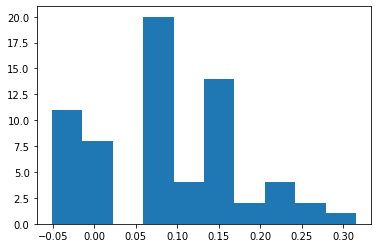

0_JDU233_WT_in_utero


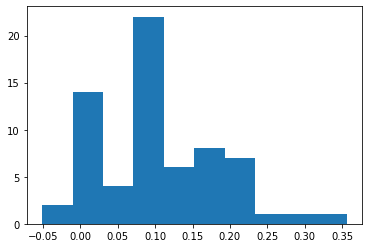

1_JDU233_knl-1


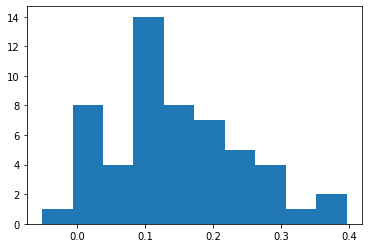

2_JDU233_him-10


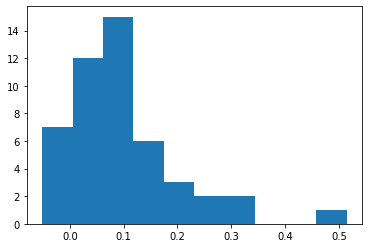

3_JDU233_zwl-1


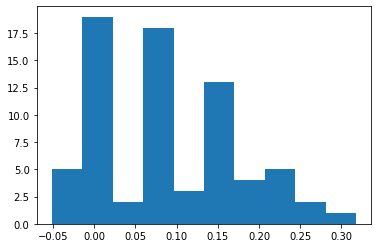

4_JDU233_him-10_zwl-1


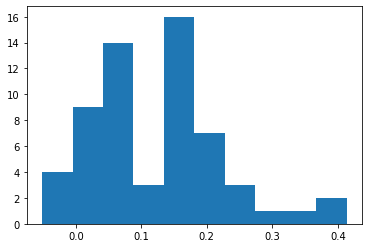

5_JDU233_gei-17


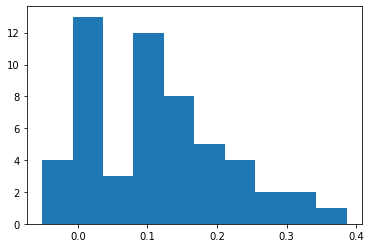

6_JDU233_klp-19


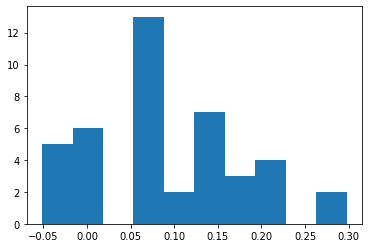

7_JDU323_WT


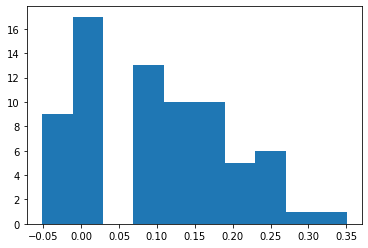

8_JDU323_knl1


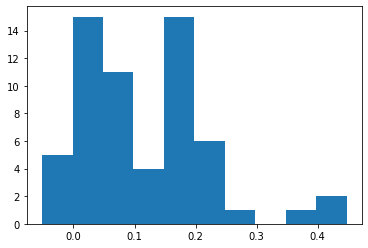

9_JDU323_knl1_him_10


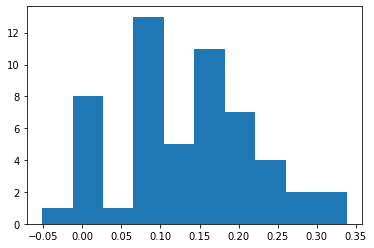

10_JDU323_knl1_zwl1


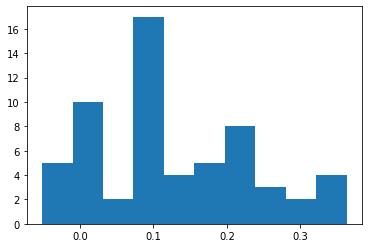

11_JDU574_WT


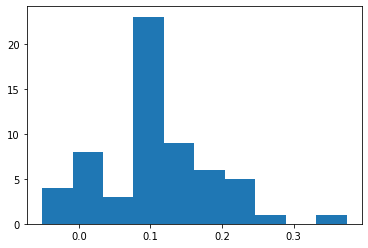

12_JDU574_zwl1


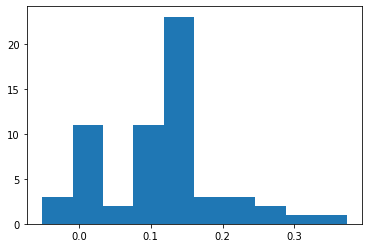

13_JDU574_zwl1_him10


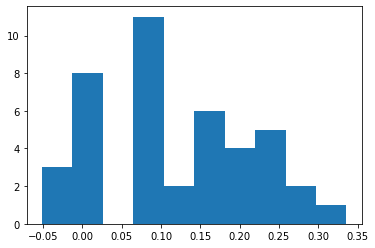

14_JDU574_zwl1_klp19


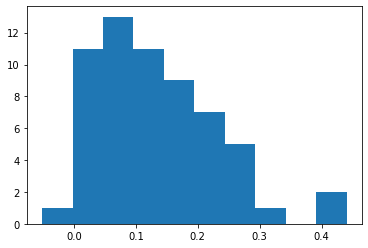

In [11]:
for cond in df_entropy.condition.unique():
    print(cond)
    df_cond = df_entropy[df_entropy.condition == cond]
    plt.hist(df_cond.iloc[:,-6:].values.flatten())
    plt.show()

<BarContainer object of 16 artists>

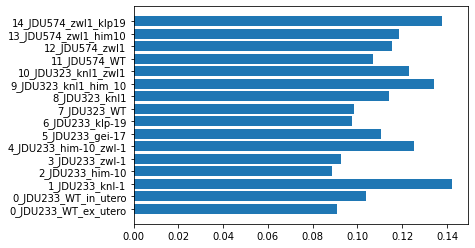

In [12]:
cond_list = []
avg_list = []
for cond in df_entropy.condition.unique():
    df_cond = df_entropy[df_entropy.condition == cond]
    avg = df_cond.iloc[:,-6:].mean().mean()
    cond_list.append(cond)
    avg_list.append(avg)
df_avg = pd.DataFrame({"cond": cond_list, "avg": avg_list})
plt.barh(df_avg.cond, df_avg.avg)

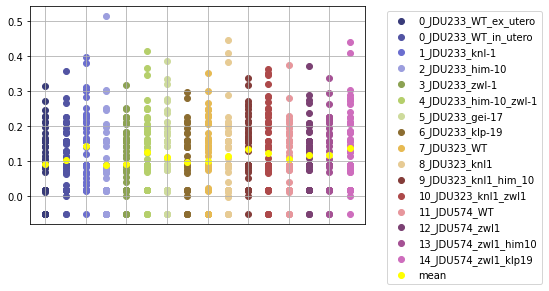

In [18]:
NUM_COLORS = len(df_entropy.condition.unique())
cm = plt.get_cmap('tab20b')
means = []
stds = []
for i, cond in enumerate(df_entropy.condition.unique()):
    df_cond = df_entropy[df_entropy.condition == cond]
    entropies = df_cond.iloc[:,-6:].values.flatten()
    mean = pd.Series(entropies).mean()
    std = pd.Series(entropies).std()
    means.append(mean)
    stds.append(stds)
    plt.scatter([i] * len(entropies), entropies, label=cond, color=cm(1.*i/NUM_COLORS))
plt.scatter(range(16), means, label="mean", color="yellow")
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(1.05, 1), loc='upper left')   
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
plt.grid()

# plt.errorbar(range(15), means, stds)

In [16]:
len(means)

16

# Cummulative Distance

In [31]:
distances = defaultdict(list)
for cond, films in dfs.items():
    for film, df in films.items():
        for chrom_idx in range(6):
            distances["Condition"].append(cond)
            distances["Film"].append(film)
            distances["Chromosome ID"].append(chrom_idx)
            df_chrom = df.iloc[:, chrom_idx]
            df_cumdist = df_chrom.diff().abs().cumsum()
            for time in df_cumdist.index[1:]:
                distances[f"Distance up to {int(time)}"].append(df_cumdist[time])
df_distances = pd.DataFrame(distances)
df_distances.head()

Condition        Film  Chromosome ID  Distance up to -190  \
0  0_JDU233_WT_ex_utero  191011_03B              0             0.311077   
1  0_JDU233_WT_ex_utero  191011_03B              1             0.328078   
2  0_JDU233_WT_ex_utero  191011_03B              2             0.226316   
3  0_JDU233_WT_ex_utero  191011_03B              3             0.176695   
4  0_JDU233_WT_ex_utero  191011_03B              4             0.223460   

   Distance up to -180  Distance up to -170  Distance up to -160  \
0             0.424801             0.425385             0.659434   
1             0.337951             0.575512             0.744245   
2             0.618625             1.316511             1.591267   
3             0.613489             1.542358             1.739158   
4             0.626313             1.171746             1.239099   

   Distance up to -150  Distance up to -140  Distance up to -130  ...  \
0             0.766001             1.013812             1.218922  ...   
1             1.002945             1.534530             1.620488  ...   
2             1.636494             1.778998             1.897025  ...   
3             2.457786             3.171417             3.576644  ...   
4             1.507183             1.896455             1.900753  ...   

   Distance up to -90  Distance up to -80  Distance up to -70  \
0            2.130222            2.503669            2.646967   
1            2.330203            2.342673            2.960699   
2            3.301302            3.665660            3.903290   
3            4.456153            4.685880            5.368642   
4            2.484416            2.618504            2.700857   

   Distance up to -60  Distance up to -50  Distance up to -40  \
0            2.737786            2.801945            2.965445   
1            3.361698            3.554673            3.648949   
2            3.923702            4.148462            4.304001   
3            5.731679            6.148379            6.289234   
4            2.839265            2.946888            3.010156   

   Distance up to -30  Distance up to -20  Distance up to -10  \
0            3.223776            3.496980            3.523732   
1            3.698092            3.953092            4.236950   
2            4.869765            5.072300            5.084490   
3            6.533294            6.619883            7.048575   
4            3.049640            3.342699            3.586893   

   Distance up to 0  
0          3.544639  
1          4.704610  
2          5.302991  
3          7.535752  
4          3.660804  

[5 rows x 23 columns]

In [32]:
df_distances.tail()

Condition       Film  Chromosome ID  Distance up to -190  \
1501  14_JDU574_zwl1_klp19  200109_10              1                  NaN   
1502  14_JDU574_zwl1_klp19  200109_10              2                  NaN   
1503  14_JDU574_zwl1_klp19  200109_10              3                  NaN   
1504  14_JDU574_zwl1_klp19  200109_10              4                  NaN   
1505  14_JDU574_zwl1_klp19  200109_10              5                  NaN   

      Distance up to -180  Distance up to -170  Distance up to -160  \
1501                  NaN                  NaN                  NaN   
1502                  NaN                  NaN                  NaN   
1503                  NaN                  NaN                  NaN   
1504                  NaN                  NaN                  NaN   
1505                  NaN                  NaN                  NaN   

      Distance up to -150  Distance up to -140  Distance up to -130  ...  \
1501                  NaN                  NaN                  NaN  ...   
1502                  NaN                  NaN                  NaN  ...   
1503                  NaN                  NaN                  NaN  ...   
1504                  NaN                  NaN                  NaN  ...   
1505                  NaN                  NaN                  NaN  ...   

      Distance up to -90  Distance up to -80  Distance up to -70  \
1501            1.839424            2.145921            2.408226   
1502            0.709844            0.855098            0.949527   
1503            0.550997            0.839019            1.218451   
1504            0.324086            0.409408            0.472043   
1505                 NaN                 NaN                 NaN   

      Distance up to -60  Distance up to -50  Distance up to -40  \
1501            2.434696            2.575187            2.713359   
1502            1.082804            1.115823            1.398831   
1503            1.376162            1.610066            1.857235   
1504            0.536159            0.691195            0.977020   
1505            0.820117            0.983026            1.253031   

      Distance up to -30  Distance up to -20  Distance up to -10  \
1501            2.783467            2.990932            3.004664   
1502            1.539192            1.666671            1.749305   
1503            1.898337            2.017084            2.069023   
1504            1.206290            1.252113            1.346026   
1505            1.535284            1.560653            1.723517   

      Distance up to 0  
1501          3.021955  
1502          1.877260  
1503          2.134255  
1504          1.358376  
1505          1.849435  

[5 rows x 23 columns]

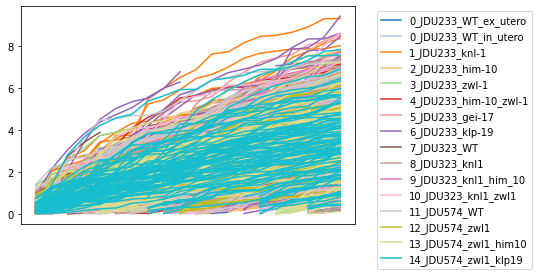

In [41]:
NUM_COLORS = len(dfs.keys())
cm = plt.get_cmap('tab20')
for i, cond in enumerate(df_distances.Condition.unique()):
    df_distance = df_distances[df_distances.Condition == cond]
    for _, row in df_distance.iterrows():
        plt.plot(row.iloc[3:], label=cond, color=cm(1.*i/NUM_COLORS))
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off    
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(1.05, 1), loc='upper left')

In [42]:
df_distances.to_csv("cummulative_distance.csv")

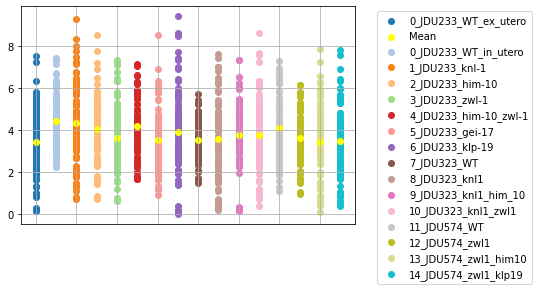

In [45]:
NUM_COLORS = len(dfs.keys())
cm = plt.get_cmap('tab20')
for i, cond in enumerate(df_distances.Condition.unique()):
    df_distance = df_distances[df_distances.Condition == cond]
    plt.scatter([i]*len(df_distance), df_distance.iloc[:,-1], label=cond, color=cm(1.*i/NUM_COLORS))
    plt.scatter([i], df_distance.iloc[:,-1].mean(), label="Mean", color="yellow")
#     for _, row in df_distance.iterrows():
#         plt.plot(row.iloc[3:], label=cond, color=cm(1.*i/NUM_COLORS))
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off    
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid()

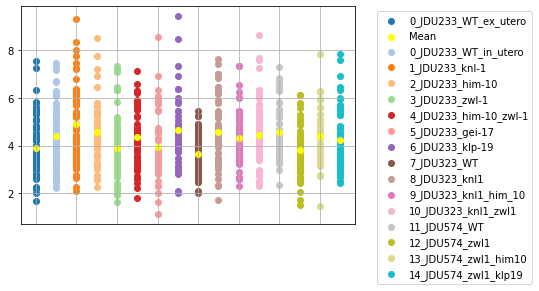

In [48]:
NUM_COLORS = len(dfs.keys())
cm = plt.get_cmap('tab20')
for i, cond in enumerate(df_distances.Condition.unique()):
    df_distance = df_distances[df_distances.Condition == cond]
    df_distance = df_distance.dropna()
    plt.scatter([i]*len(df_distance), df_distance.iloc[:,-1], label=cond, color=cm(1.*i/NUM_COLORS))
    plt.scatter([i], df_distance.iloc[:,-1].mean(), label="Mean", color="yellow")
#     for _, row in df_distance.iterrows():
#         plt.plot(row.iloc[3:], label=cond, color=cm(1.*i/NUM_COLORS))
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off    
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid()

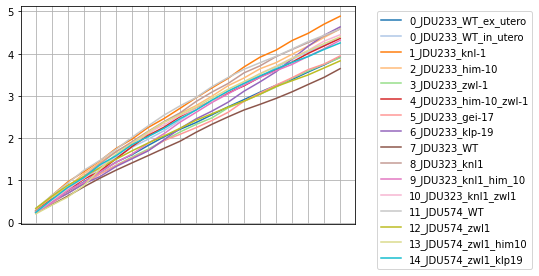

In [52]:
NUM_COLORS = len(dfs.keys())
cm = plt.get_cmap('tab20')
for i, cond in enumerate(df_distances.Condition.unique()):
    df_distance = df_distances[df_distances.Condition == cond]
    df_distance = df_distance.dropna()
    plt.plot(df_distance.iloc[:,3:].mean(), label=cond, color=cm(1.*i/NUM_COLORS))
#     break
#     plt.scatter([i]*len(df_distance), df_distance.iloc[:,-1], label=cond, color=cm(1.*i/NUM_COLORS))
#     plt.scatter([i], df_distance.iloc[:,-1].mean(), label="Mean", color="yellow")
# #     for _, row in df_distance.iterrows():
# #         plt.plot(row.iloc[3:], label=cond, color=cm(1.*i/NUM_COLORS))
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off    
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid()

In [54]:
df_distances.tail()

Condition       Film  Chromosome ID  Distance up to -190  \
1501  14_JDU574_zwl1_klp19  200109_10              1                  NaN   
1502  14_JDU574_zwl1_klp19  200109_10              2                  NaN   
1503  14_JDU574_zwl1_klp19  200109_10              3                  NaN   
1504  14_JDU574_zwl1_klp19  200109_10              4                  NaN   
1505  14_JDU574_zwl1_klp19  200109_10              5                  NaN   

      Distance up to -180  Distance up to -170  Distance up to -160  \
1501                  NaN                  NaN                  NaN   
1502                  NaN                  NaN                  NaN   
1503                  NaN                  NaN                  NaN   
1504                  NaN                  NaN                  NaN   
1505                  NaN                  NaN                  NaN   

      Distance up to -150  Distance up to -140  Distance up to -130  ...  \
1501                  NaN                  NaN                  NaN  ...   
1502                  NaN                  NaN                  NaN  ...   
1503                  NaN                  NaN                  NaN  ...   
1504                  NaN                  NaN                  NaN  ...   
1505                  NaN                  NaN                  NaN  ...   

      Distance up to -90  Distance up to -80  Distance up to -70  \
1501            1.839424            2.145921            2.408226   
1502            0.709844            0.855098            0.949527   
1503            0.550997            0.839019            1.218451   
1504            0.324086            0.409408            0.472043   
1505                 NaN                 NaN                 NaN   

      Distance up to -60  Distance up to -50  Distance up to -40  \
1501            2.434696            2.575187            2.713359   
1502            1.082804            1.115823            1.398831   
1503            1.376162            1.610066            1.857235   
1504            0.536159            0.691195            0.977020   
1505            0.820117            0.983026            1.253031   

      Distance up to -30  Distance up to -20  Distance up to -10  \
1501            2.783467            2.990932            3.004664   
1502            1.539192            1.666671            1.749305   
1503            1.898337            2.017084            2.069023   
1504            1.206290            1.252113            1.346026   
1505            1.535284            1.560653            1.723517   

      Distance up to 0  
1501          3.021955  
1502          1.877260  
1503          2.134255  
1504          1.358376  
1505          1.849435  

[5 rows x 23 columns]

In [55]:
df_distances_complete = df_distances.dropna()

In [56]:
df_distances_complete.tail()

Condition       Film  Chromosome ID  Distance up to -190  \
1477  14_JDU574_zwl1_klp19  200221_05              1             0.509097   
1478  14_JDU574_zwl1_klp19  200221_05              2             0.728993   
1479  14_JDU574_zwl1_klp19  200221_05              3             0.470951   
1480  14_JDU574_zwl1_klp19  200221_05              4             0.343527   
1481  14_JDU574_zwl1_klp19  200221_05              5             0.549148   

      Distance up to -180  Distance up to -170  Distance up to -160  \
1477             0.837762             0.944402             0.959606   
1478             1.206844             1.350375             1.667829   
1479             0.589727             0.744904             0.755008   
1480             0.655363             0.771103             1.162189   
1481             0.868647             1.021494             1.511671   

      Distance up to -150  Distance up to -140  Distance up to -130  ...  \
1477             1.436196             1.625916             1.768921  ...   
1478             2.235896             2.507398             2.824242  ...   
1479             0.876729             1.188183             1.265568  ...   
1480             1.732222             1.766719             1.862380  ...   
1481             2.105859             2.835682             3.352671  ...   

      Distance up to -90  Distance up to -80  Distance up to -70  \
1477            2.602487            3.174269            3.241451   
1478            3.959864            4.200537            4.348754   
1479            1.979585            2.067366            2.164555   
1480            2.833310            3.217675            3.387981   
1481            4.330777            4.674786            4.803651   

      Distance up to -60  Distance up to -50  Distance up to -40  \
1477            3.461775            3.543027            3.964648   
1478            4.505213            4.655303            4.877366   
1479            2.175711            2.290757            2.547960   
1480            3.481419            3.602670            3.747328   
1481            5.009169            5.044175            5.289880   

      Distance up to -30  Distance up to -20  Distance up to -10  \
1477            4.178711            4.315164            4.518719   
1478            5.062938            5.123121            5.596649   
1479            2.826621            3.234563            3.456583   
1480            4.175715            4.218709            4.623830   
1481            5.528858            5.553751            5.648839   

      Distance up to 0  
1477          4.534141  
1478          5.641301  
1479          3.558871  
1480          4.758454  
1481          5.675192  

[5 rows x 23 columns]

In [57]:
df_distances_complete.to_csv("cummulative_distance_completeonly.csv")

In [58]:
len(df_distances)

1506

In [59]:
len(df_distances_complete)

945